In [1]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random



In [2]:
ROOT = "./research_network"
loaded_tables = {}

# find folders that contain part.0.parquet
folders = sorted(set(os.path.dirname(p) for p in glob.glob(f"{ROOT}/**/part.0.parquet", recursive=True)))

for folder in folders:
    folder_name = os.path.basename(folder)
    table_name = re.sub(r"\.parquet$", "", folder_name)

    part_files = sorted(glob.glob(os.path.join(folder, "part.*.parquet")))
    if not part_files:
        print(f"⚠️ No part files found in {folder}")
        continue

    dfs = []
    for f in part_files:
        try:
            dfs.append(pd.read_parquet(f))
        except Exception as e:
            print(f"❌ Error reading {f}: {e}")

    df = pd.concat(dfs, ignore_index=True)

    # rename exact 'code' columns to {table_name}_code
    rename_map = {c: f"{table_name}_code" for c in df.columns if c.strip().lower() == "code"}
    if rename_map:
        df.rename(columns=rename_map, inplace=True)
        print(f"✅ Renamed in '{table_name}': {rename_map}")

    df["source_name"] = table_name
    loaded_tables[table_name] = df
    globals()[table_name] = df  # optional

    print(f"✅ Loaded '{table_name}' ({len(part_files)} parts) → shape {df.shape}")

print("\nSummary of merged tables:")
for name, df in loaded_tables.items():
    print(f"  • {name:<20} {df.shape[0]} rows × {df.shape[1]} cols")


✅ Renamed in 'diagnosis': {'code': 'diagnosis_code'}
✅ Loaded 'diagnosis' (1605 parts) → shape (4296949, 11)
✅ Loaded 'encounter' (568 parts) → shape (1696490, 10)
✅ Renamed in 'lab_result': {'code': 'lab_result_code'}
✅ Loaded 'lab_result' (3711 parts) → shape (9991613, 11)
✅ Renamed in 'medication_drug': {'code': 'medication_drug_code'}
✅ Loaded 'medication_drug' (2250 parts) → shape (3790635, 14)
✅ Renamed in 'medication_ingredient': {'code': 'medication_ingredient_code'}
✅ Loaded 'medication_ingredient' (5419 parts) → shape (10427367, 12)
✅ Loaded 'patient' (5 parts) → shape (9999, 12)
✅ Renamed in 'procedure': {'code': 'procedure_code'}
✅ Loaded 'procedure' (961 parts) → shape (3098180, 9)
✅ Renamed in 'vitals_signs': {'code': 'vitals_signs_code'}
✅ Loaded 'vitals_signs' (1839 parts) → shape (4964930, 11)

Summary of merged tables:
  • diagnosis            4296949 rows × 11 cols
  • encounter            1696490 rows × 10 cols
  • lab_result           9991613 rows × 11 cols
  • med

In [3]:
# --- Use the already-loaded procedure table ---
df = loaded_tables['procedure'].copy()
print(f"Procedure table shape: {df.shape}")
df.head(10)



Procedure table shape: (3098180, 9)


,patient_id,encounter_id,code_system,procedure_code,principal_procedure_indicator,date,derived_by_TriNetX,source_id,source_name
0,oQWB,rQ8,CPT,96361,Unknown,20160701,F,EHR,procedure
1,oQWB,rg8,CPT,96372,Unknown,20160712,F,EHR,procedure
2,oQWB,rg8,CPT,96372,Unknown,20160713,F,EHR,procedure
3,oQWB,rQ8,CPT,96374,Unknown,20160701,F,EHR,procedure
4,oQWB,rg8,CPT,96374,Unknown,20160712,F,EHR,procedure
5,oQWB,rw8,CPT,96374,Unknown,20160722,F,EHR,procedure
6,oQWB,rA9,CPT,99284,Unknown,20140423,F,EHR,procedure
7,oQWB,rQ8,CPT,99284,Unknown,20160701,F,EHR,procedure
8,oQWB,rg8,CPT,99284,Unknown,20160712,F,EHR,procedure
9,oQWB,rQ9,CPT,99284,Unknown,20161023,F,EHR,procedure


In [4]:
# --- Use the already-loaded procedure table ---
df = loaded_tables['patient'].copy()
print(f"Patient table shape: {df.shape}")
df.head(10)

Patient table shape: (9999, 12)


,patient_id,sex,race,ethnicity,marital_status,year_of_birth,reason_yob_missing,month_year_death,death_date_source_id,patient_regional_location,source_id,source_name
0,GAzE,F,White,Not Hispanic or Latino,Unknown,1955,Present,None,None,Pacific,EHR,patient
1,GwU,F,Unknown,Not Hispanic or Latino,Unknown,1940,Present,None,None,Pacific,EHR,patient
2,GQZ,M,Asian,Not Hispanic or Latino,Unknown,1963,Present,None,None,Pacific,EHR,patient
3,GQq,M,Unknown,Unknown,Unknown,1953,Present,None,None,Pacific,EHR,patient
4,GAv,F,Other Race,Hispanic or Latino,Unknown,1990,Present,None,None,Pacific,EHR,patient
5,GgGB,F,Unknown,Unknown,Unknown,1966,Present,None,None,Pacific,EHR,patient
6,GgmB,F,Other Race,Hispanic or Latino,Unknown,1988,Present,None,None,Pacific,EHR,patient
7,GAoB,M,Unknown,Unknown,Unknown,1979,Present,None,None,Pacific,EHR,patient
8,GAwC,F,Black or African American,Unknown,Unknown,1992,Present,None,None,Pacific,EHR,patient
9,gQAH,F,Black or African American,Not Hispanic or Latino,Single,1954,Present,None,None,Middle Atlantic,EHR,patient


# Telehealth codes

In [5]:
# === Add ALL telehealth codes (with time/scope details)===
# Format: code -> [telehealth_type, provider, time_or_scope]

telehealth_map = {}  # or keep your existing one and keep the .update(...) calls below

# 1) Online Digital Visits (E-Visits)
telehealth_map.update({
    "99421": ["Online Digital Visit (E-Visit)", "Physician/QHP", "5–10 min cumulative over 7 days"],
    "99422": ["Online Digital Visit (E-Visit)", "Physician/QHP", "11–20 min cumulative over 7 days"],
    "99423": ["Online Digital Visit (E-Visit)", "Physician/QHP", "21+ min cumulative over 7 days"],
    "98970": ["Online Digital Visit (E-Visit)", "Non-physician/clinical staff", "5–10 min cumulative over 7 days"],
    "98971": ["Online Digital Visit (E-Visit)", "Non-physician/clinical staff", "11–20 min cumulative over 7 days"],
    "98972": ["Online Digital Visit (E-Visit)", "Non-physician/clinical staff", "21+ min cumulative over 7 days"],
    "G2061": ["Online Digital Visit (E-Visit)", "PT/OT/SLP", "5–10 min cumulative over 7 days"],
    "G2062": ["Online Digital Visit (E-Visit)", "PT/OT/SLP", "11–20 min cumulative over 7 days"],
    "G2063": ["Online Digital Visit (E-Visit)", "PT/OT/SLP", "21+ min cumulative over 7 days"],
})

# 2) Communication Technology-Based Services (Virtual Check-Ins)
# NOTE: CPT 98016 (5–10 min) replaces HCPCS G2012 for Medicare in 2025, but keep G2012 for plans still using it.
telehealth_map.update({
    "98016": ["Virtual Check-In", "Physician/QHP", "5–10 min medical discussion (patient-initiated)"],  # replaces G2012 for Medicare CY2025
    "G2012": ["Virtual Check-In", "Physician/QHP", "5–10 min medical discussion (patient-initiated)"],   # legacy; payer-dependent
    "G2252": ["Virtual Check-In", "Physician/QHP", "11–20 min medical discussion"],
    "G2251": ["Virtual Check-In", "QHP who CANNOT bill E/M", "5–10 min medical discussion"],
    "G2250": ["Remote eval of video/images", "QHP who CANNOT bill E/M", "Review prerecorded images/video; follow-up required"],
})

# 3) Remote Physiologic Monitoring (RPM)
telehealth_map.update({
    "99091": ["Remote Physiologic Monitoring (RPM)", "Physician/QHP", "30 min data review & interpretation (per month)"],
    "99453": ["Remote Physiologic Monitoring (RPM)", "Clinical staff", "Initial device setup & patient education (per episode)"],
    "99454": ["Remote Physiologic Monitoring (RPM)", "Device supply", "Device supply + data transmission (per 30 days)"],
    "99457": ["Remote Physiologic Monitoring (RPM)", "Physician/QHP", "First 20 min treatment management (per month)"],
    "99458": ["Remote Physiologic Monitoring (RPM)", "Physician/QHP", "Each additional 20 min (per month)"],
    "99473": ["Self-measured BP (RPM adjunct)", "Patient", "Device setup/calibration"],
    "99474": ["Self-measured BP (RPM adjunct)", "Physician/QHP", "Data review/report & treatment plan"],
    "G2010": ["Store-and-Forward (Asynchronous)", "Physician/QHP", "Remote evaluation of recorded video/images with 24-hr follow-up"],
})

# 4) Video-Supported Telehealth (Synchronous audio-video)
telehealth_map.update({
    "G0425": ["Video-Supported Telehealth", "Physician/QHP", "Outpatient consult – 30 min"],
    "G0426": ["Video-Supported Telehealth", "Physician/QHP", "Outpatient consult – 50 min"],
    "G0427": ["Video-Supported Telehealth", "Physician/QHP", "Outpatient consult – 70+ min"],
    "G0406": ["Video-Supported Telehealth", "Physician", "ESRD-related visit (monthly)"],
    "G0407": ["Video-Supported Telehealth", "Physician", "ESRD-related visit (q2–3 months)"],
    "G0408": ["Video-Supported Telehealth", "Physician", "ESRD-related visit (≥4 months)"],
    "G0459": ["Video-Supported Telehealth", "Physician", "Neurobehavioral status exam"],
    "G0508": ["Video-Supported Telehealth", "Physician", "Critical care telehealth – initial 60 min"],
    "G0509": ["Video-Supported Telehealth", "Physician", "Critical care telehealth – each additional 30 min"],
     "Q3014": ["Telehealth Facility Fee (indicative of Telehealth)", "Facility", "Originating site facility fee (non-professional)"],  
    "T1014": ["Telehealth Transmission", "Facility", "Telehealth transmission charge"],
})

# 5) Telephone (Audio-only) E/M
telehealth_map.update({
    "99441": ["Telephone (Audio-Only) E/M", "Physician/QHP", "5–10 min medical discussion"],
    "99442": ["Telephone (Audio-Only) E/M", "Physician/QHP", "11–20 min medical discussion"],
    "99443": ["Telephone (Audio-Only) E/M", "Physician/QHP", "21–30+ min medical discussion"],
    "98966": ["Telephone (Audio-Only) – Clinical Staff", "Non-physician/clinical staff", "5–10 min assessment & management"],
    "98967": ["Telephone (Audio-Only) – Clinical Staff", "Non-physician/clinical staff", "11–20 min assessment & management"],
    "98968": ["Telephone (Audio-Only) – Clinical Staff", "Non-physician/clinical staff", "21–30 min assessment & management"],
})

# 6) Interprofessional (Telephone/Internet/EHR) Consults (provider-to-provider)
telehealth_map.update({
    "99446": ["Interprofessional Consult (Phone/Internet/EHR)", "Provider-to-provider", "5–10 min discussion"],
    "99447": ["Interprofessional Consult (Phone/Internet/EHR)", "Provider-to-provider", "11–20 min discussion"],
    "99448": ["Interprofessional Consult (Phone/Internet/EHR)", "Provider-to-provider", "21–30 min discussion"],
    "99449": ["Interprofessional Consult (Phone/Internet/EHR)", "Provider-to-provider", "31+ min discussion"],
    "99451": ["Interprofessional Consult (EHR/written)", "Provider-to-provider", "Written report (≥5 min)"],
    "99452": ["Interprofessional Consult (coordination)", "Provider-to-provider", "16–30 min preparation/communication"],
})





# Non-Specified Codes

9) HARD-CODED: Non-Specified Telehealth-Eligible Codes (All unified) 

telehealth_map.update({
    # Home/Domiciliary/Assisted Living Visits
    "99325": ["Non-Specified (Telehealth or In-Person)", "E/M – Domiciliary", "New patient, 25 min"],
    "99326": ["Non-Specified (Telehealth or In-Person)", "E/M – Domiciliary", "New patient, 40 min"],
    "99327": ["Non-Specified (Telehealth or In-Person)", "E/M – Domiciliary", "New patient, 60 min"],
    "99328": ["Non-Specified (Telehealth or In-Person)", "E/M – Domiciliary", "New patient, 75+ min"],
    "99334": ["Non-Specified (Telehealth or In-Person)", "E/M – Domiciliary", "Established patient, 15 min"],
    "99335": ["Non-Specified (Telehealth or In-Person)", "E/M – Domiciliary", "Established patient, 25 min"],
    "99336": ["Non-Specified (Telehealth or In-Person)", "E/M – Domiciliary", "Established patient, 40 min"],
    "99337": ["Non-Specified (Telehealth or In-Person)", "E/M – Domiciliary", "Established patient, 60 min"],

    # Home Visits
    "99341": ["Non-Specified (Telehealth or In-Person)", "E/M – Home", "New patient, 15 min"],
    "99342": ["Non-Specified (Telehealth or In-Person)", "E/M – Home", "New patient, 30 min"],
    "99343": ["Non-Specified (Telehealth or In-Person)", "E/M – Home", "New patient, 45 min"],
    "99344": ["Non-Specified (Telehealth or In-Person)", "E/M – Home", "New patient, 60 min"],
    "99345": ["Non-Specified (Telehealth or In-Person)", "E/M – Home", "New patient, 75 min"],
    "99347": ["Non-Specified (Telehealth or In-Person)", "E/M – Home", "Established patient, 15 min"],
    "99348": ["Non-Specified (Telehealth or In-Person)", "E/M – Home", "Established patient, 25 min"],
    "99349": ["Non-Specified (Telehealth or In-Person)", "E/M – Home", "Established patient, 40 min"],
    "99350": ["Non-Specified (Telehealth or In-Person)", "E/M – Home", "Established patient, 60 min"],

    # Prolonged Services
    "99354": ["Non-Specified (Telehealth or In-Person)", "Prolonged E/M", "First hour beyond typical service"],
    "99355": ["Non-Specified (Telehealth or In-Person)", "Prolonged E/M", "Each additional 30 min"],
    "99356": ["Non-Specified (Telehealth or In-Person)", "Prolonged Inpatient", "First hour beyond initial service"],
    "99357": ["Non-Specified (Telehealth or In-Person)", "Prolonged Inpatient", "Each additional 30 min"],

    # Counseling / Preventive & Chronic Care
    "99406": ["Non-Specified (Telehealth or In-Person)", "Behavioral Counseling", "Smoking/tobacco cessation, 3–10 min"],
    "99407": ["Non-Specified (Telehealth or In-Person)", "Behavioral Counseling", "Smoking/tobacco cessation, >10 min"],

    # Critical Care Neonatal/Peds
    "99468": ["Non-Specified (Telehealth or In-Person)", "Neonatal Critical Care", "Initial day"],
    "99469": ["Non-Specified (Telehealth or In-Person)", "Neonatal Critical Care", "Subsequent day"],
    "99471": ["Non-Specified (Telehealth or In-Person)", "Pediatric Critical Care", "Initial, <6 years"],
    "99472": ["Non-Specified (Telehealth or In-Person)", "Pediatric Critical Care", "Subsequent, <6 years"],
    "99475": ["Non-Specified (Telehealth or In-Person)", "Pediatric Critical Care", "Initial, 6–11 years"],
    "99476": ["Non-Specified (Telehealth or In-Person)", "Pediatric Critical Care", "Subsequent, 6–11 years"],
    "99477": ["Non-Specified (Telehealth or In-Person)", "Perinatal Care", "Initial hospital care, per day"],
    "99478": ["Non-Specified (Telehealth or In-Person)", "Perinatal Care", "Subsequent intensive, <1500g"],
    "99479": ["Non-Specified (Telehealth or In-Person)", "Perinatal Care", "Subsequent intensive, 1500–2500g"],
    "99480": ["Non-Specified (Telehealth or In-Person)", "Perinatal Care", "Subsequent intensive, ≥2500g"],

    # Cognitive Assessment
    "99483": ["Non-Specified (Telehealth or In-Person)", "Cognitive Assessment", "Comprehensive cognitive evaluation"],

    # Transitional Care
    "99495": ["Non-Specified (Telehealth or In-Person)", "TCM – Transitional Care Management", "Communication ≤2 days post-discharge, 14-day F/U"],
    "99496": ["Non-Specified (Telehealth or In-Person)", "TCM – Transitional Care Management", "Communication ≤2 days post-discharge, 7-day F/U"],

    # Advance Care Planning
    "99497": ["Non-Specified (Telehealth or In-Person)", "Advance Care Planning", "First 30 min"],
    "99498": ["Non-Specified (Telehealth or In-Person)", "Advance Care Planning", "Each additional 30 min"],

    # ABA / Adaptive Behavior
    "0362T": ["Non-Specified (Telehealth or In-Person)", "Applied Behavior Analysis", "Behavior ID support assessment, each 15 min"],
    "0373T": ["Non-Specified (Telehealth or In-Person)", "Applied Behavior Analysis", "Adaptive behavior treatment, each 15 min, 2+ techs"],

    # Diabetes Self-Management
    "G0108": ["Non-Specified (Telehealth or In-Person)", "Diabetes Education", "Individual, 30 min"],
    "G0109": ["Non-Specified (Telehealth or In-Person)", "Diabetes Education", "Group, 30 min"],

    # Nutrition
    "G0270": ["Non-Specified (Telehealth or In-Person)", "Nutrition Therapy", "Re-assessment, 15 min"],

    # Preventive / Screening / Wellness
    "G0296": ["Non-Specified (Telehealth or In-Person)", "Preventive", "Shared decision making for lung cancer screening"],
    "G0396": ["Non-Specified (Telehealth or In-Person)", "SBIRT", "15–30 min alcohol/substance counseling"],
    "G0397": ["Non-Specified (Telehealth or In-Person)", "SBIRT", "≥30 min alcohol/substance counseling"],
    "G0410": ["Non-Specified (Telehealth or In-Person)", "Group Psychotherapy", "45–50 min"],
    "G0420": ["Non-Specified (Telehealth or In-Person)", "Diabetes Training", "Individual, 30 min"],
    "G0421": ["Non-Specified (Telehealth or In-Person)", "Diabetes Training", "Group, 30 min"],
    "G0436": ["Non-Specified (Telehealth or In-Person)", "Behavioral Counseling", "Smoking cessation, 3–10 min"],
    "G0437": ["Non-Specified (Telehealth or In-Person)", "Behavioral Counseling", "Smoking cessation, >10 min"],
    "G0438": ["Non-Specified (Telehealth or In-Person)", "Preventive", "Initial annual wellness visit"],
    "G0439": ["Non-Specified (Telehealth or In-Person)", "Preventive", "Subsequent annual wellness visit"],
    "G0442": ["Non-Specified (Telehealth or In-Person)", "Preventive", "Annual alcohol misuse screening"],
    "G0443": ["Non-Specified (Telehealth or In-Person)", "Preventive", "Brief alcohol misuse counseling"],
    "G0444": ["Non-Specified (Telehealth or In-Person)", "Preventive", "Annual depression screening"],
    "G0445": ["Non-Specified (Telehealth or In-Person)", "Preventive", "STI prevention counseling"],
    "G0446": ["Non-Specified (Telehealth or In-Person)", "Preventive", "Cardiovascular risk reduction, 15 min"],
    "G0447": ["Non-Specified (Telehealth or In-Person)", "Preventive", "Obesity behavioral therapy, 15 min"],
    "G0506": ["Non-Specified (Telehealth or In-Person)", "Care Management", "Comprehensive care plan assessment"],
    "G0513": ["Non-Specified (Telehealth or In-Person)", "Behavioral Therapy", "Group therapy, first 60 min"],
    "G0514": ["Non-Specified (Telehealth or In-Person)", "Behavioral Therapy", "Group therapy, each additional 30 min"],

    # OUD Collaborative Care
    "G2086": ["Non-Specified (Telehealth or In-Person)", "OUD Care", "Initial month, 70 min"],
    "G2087": ["Non-Specified (Telehealth or In-Person)", "OUD Care", "Subsequent month, 60 min"],
    "G2088": ["Non-Specified (Telehealth or In-Person)", "OUD Care", "Each additional 30 min"],

    # Behavioral Health / OUD
    "G9685": ["Non-Specified (Telehealth or In-Person)", "Behavioral Health/OUD", "Care coordination/management"],

    # Speech Therapy
    "S9152": ["Non-Specified (Telehealth or In-Person)", "Speech Therapy", "Speech therapy per session"],
})


In [177]:
# Analyze VR encounters: Check overlap with telehealth codes, then non-specific codes
# Show procedure codes that are NOT overlapped
print("=" * 80)
print("ANALYZING VR ENCOUNTERS: OVERLAP WITH TELEHEALTH AND NON-SPECIFIC CODES")
print("=" * 80)

# Step 1: Find all VR encounters
print("\n1️⃣ Finding VR encounters...")
encounter_type_col = None
for col in encounter.columns:
    if 'type' in col.lower():
        encounter_type_col = col
        break

if not encounter_type_col:
    print("⚠️ Could not find encounter type column")
    print(f"Available columns: {encounter.columns.tolist()}")
else:
    vr_encounters = encounter[encounter[encounter_type_col] == 'VR'].copy()
    vr_encounter_ids = set(vr_encounters['encounter_id'].unique())
    
    print(f"   Found {len(vr_encounters):,} VR encounters")
    print(f"   Unique VR encounter_ids: {len(vr_encounter_ids):,}")
    
    # Step 2: Get all procedures for VR encounters
    print("\n2️⃣ Getting procedures for VR encounters...")
    vr_procedures = procedure[
        procedure['encounter_id'].isin(vr_encounter_ids)
    ].copy()
    
    # Count how many VR encounters have at least one procedure
    vr_encounters_with_procedures = vr_procedures['encounter_id'].nunique()
    print(f"   VR encounters with procedure codes: {vr_encounters_with_procedures:,}")
    print(f"   Total procedures in VR encounters: {len(vr_procedures):,}")
    print(f"   Unique procedure codes: {vr_procedures['procedure_code'].nunique():,}")
    
    # Print procedure codes in VR encounters
    if len(vr_procedures) > 0:
        print(f"\n   Procedure codes in VR encounters (sorted by frequency):")
        print("   " + "-" * 76)
        proc_code_counts = vr_procedures['procedure_code'].value_counts()
        for code, count in proc_code_counts.head(50).items():
            percentage = (count / len(vr_procedures)) * 100
            print(f"     {code}: {count:,} ({percentage:.2f}%)")
        
        if len(proc_code_counts) > 50:
            print(f"\n   ... and {len(proc_code_counts) - 50} more procedure codes")
        
        print(f"\n   All unique procedure codes in VR encounters ({len(proc_code_counts):,} total):")
        all_codes = sorted(proc_code_counts.index.tolist())
        # Print in columns for better readability
        for i in range(0, len(all_codes), 10):
            codes_chunk = all_codes[i:i+10]
            print(f"     {', '.join(codes_chunk)}")
    
    # Step 3: Check overlap with telehealth codes
    print("\n3️⃣ Checking overlap with TELEHEALTH codes...")
    vr_procedures['is_telehealth'] = vr_procedures['procedure_code'].astype(str).str.upper().isin(
        [code.upper() for code in telehealth_map.keys()]
    )
    
    telehealth_in_vr = vr_procedures[vr_procedures['is_telehealth'] == True]
    print(f"   Procedures matching telehealth codes: {len(telehealth_in_vr):,}")
    print(f"   Percentage: {len(telehealth_in_vr)/len(vr_procedures)*100:.2f}%")
    
    if len(telehealth_in_vr) > 0:
        print(f"\n   Telehealth procedure codes found in VR encounters:")
        tele_codes = telehealth_in_vr['procedure_code'].value_counts()
        for code, count in tele_codes.head(20).items():
            print(f"     {code}: {count:,}")
    
    # Step 4: Check overlap with non-specific codes
    print("\n4️⃣ Checking overlap with NON-SPECIFIC codes...")
    non_specific_codes = [code for code, details in telehealth_map.items() 
                          if 'Non-Specified' in details[0]]
    
    print(f"   Total non-specific codes defined: {len(non_specific_codes):,}")
    print(f"   Non-specific codes: {', '.join(sorted(non_specific_codes))}")
    
    vr_procedures['is_non_specific'] = vr_procedures['procedure_code'].astype(str).str.upper().isin(
        [code.upper() for code in non_specific_codes]
    )
    
    nonspecific_in_vr = vr_procedures[vr_procedures['is_non_specific'] == True]
    print(f"   Procedures matching non-specific codes: {len(nonspecific_in_vr):,}")
    print(f"   Percentage: {len(nonspecific_in_vr)/len(vr_procedures)*100:.2f}%")
    
    # Always show overlap information
    print(f"\n   📊 OVERLAP ANALYSIS - Non-Specific Codes:")
    print("   " + "-" * 76)
    
    if len(nonspecific_in_vr) > 0:
        nonspec_codes = nonspecific_in_vr['procedure_code'].value_counts()
        
        # Show which non-specific codes actually appear in VR
        codes_in_vr = set(nonspec_codes.index.tolist())
        codes_not_in_vr = set(non_specific_codes) - codes_in_vr
        
        print(f"\n   ✅ Non-specific codes that OVERLAP with VR encounters ({len(codes_in_vr):,} codes):")
        for code, count in sorted(nonspec_codes.items(), key=lambda x: x[1], reverse=True):
            percentage = (count / len(nonspecific_in_vr)) * 100
            code_info = telehealth_map.get(code, ['Unknown', 'Unknown', 'Unknown'])
            print(f"     {code} ({code_info[0]}): {count:,} occurrences ({percentage:.2f}% of non-specific in VR)")
        
        if len(codes_not_in_vr) > 0:
            print(f"\n   ❌ Non-specific codes that do NOT appear in VR encounters ({len(codes_not_in_vr):,} codes):")
            for code in sorted(codes_not_in_vr):
                code_info = telehealth_map.get(code, ['Unknown', 'Unknown', 'Unknown'])
                print(f"     {code} ({code_info[0]})")
    else:
        print(f"\n   ❌ No non-specific codes found in VR encounters")
        print(f"   All {len(non_specific_codes):,} non-specific codes do NOT overlap with VR encounters")
    
    # Step 5: Find procedures that are NOT overlapped (neither telehealth nor non-specific)
    print("\n" + "=" * 80)
    print("5️⃣ NON-OVERLAPPED PROCEDURE CODES")
    print("=" * 80)
    print("(Codes that are neither telehealth nor non-specific)")
    
    vr_procedures['is_overlapped'] = vr_procedures['is_telehealth'] | vr_procedures['is_non_specific']
   
    print(f"   Percentage of all VR procedures: {len(non_overlapped)/len(vr_procedures)*100:.2f}%")
    
    
    # Summary by encounter
    print("\n6️⃣ Summary by encounter:")
    encounter_summary = vr_procedures.groupby('encounter_id').agg({
        'procedure_code': 'count',
        'is_telehealth': 'sum',
        'is_non_specific': 'sum',
        'is_overlapped': 'sum'
    }).reset_index()
    encounter_summary.columns = ['encounter_id', 'total_procedures', 'telehealth_count', 'nonspecific_count', 'overlapped_count']
    encounter_summary['non_overlapped_count'] = encounter_summary['total_procedures'] - encounter_summary['overlapped_count']
    
    print(f"   Encounters with telehealth codes: {(encounter_summary['telehealth_count'] > 0).sum():,}")
    print(f"   Encounters with non-specific codes: {(encounter_summary['nonspecific_count'] > 0).sum():,}")
    print(f"   Encounters with non-overlapped codes: {(encounter_summary['non_overlapped_count'] > 0).sum():,}")
    print(f"   Encounters with ONLY non-overlapped codes: {(encounter_summary['overlapped_count'] == 0).sum():,}")


ANALYZING VR ENCOUNTERS: OVERLAP WITH TELEHEALTH AND NON-SPECIFIC CODES

1️⃣ Finding VR encounters...
   Found 33,201 VR encounters
   Unique VR encounter_ids: 32,792

2️⃣ Getting procedures for VR encounters...
   VR encounters with procedure codes: 1,713
   Total procedures in VR encounters: 2,751
   Unique procedure codes: 225

   Procedure codes in VR encounters (sorted by frequency):
   ----------------------------------------------------------------------------
     99214: 588 (21.37%)
     99213: 401 (14.58%)
     99443: 162 (5.89%)
     99442: 162 (5.89%)
     99215: 115 (4.18%)
     Q3014: 113 (4.11%)
     G0463: 98 (3.56%)
     90834: 89 (3.24%)
     99441: 66 (2.40%)
     G2211: 57 (2.07%)
     99078: 55 (2.00%)
     99212: 49 (1.78%)
     99211: 39 (1.42%)
     99024: 39 (1.42%)
     36415: 39 (1.42%)
     99204: 31 (1.13%)
     99203: 23 (0.84%)
     90832: 23 (0.84%)
     G0439: 21 (0.76%)
     T1016: 18 (0.65%)
     85025: 16 (0.58%)
     99205: 15 (0.55%)
     93793: 14

In [178]:
# Compare Non-Specified codes with Encounter Type to identify telehealth
print("=" * 80)
print("COMPARING NON-SPECIFIED TELEHEALTH CODES WITH ENCOUNTER TYPE")
print("=" * 80)

# Get all Non-Specified codes from telehealth_map
non_specified_codes = [code for code, info in telehealth_map.items() 
                      if info[0] == "Non-Specified (Telehealth or In-Person)"]

print(f"\n📋 Non-Specified codes found: {len(non_specified_codes)}")
print(f"   Sample codes: {non_specified_codes[:10]}...")

# Merge procedure with encounter to get encounter type
procedure_with_encounter = procedure.merge(
    encounter[['encounter_id', 'type']],
    on='encounter_id',
    how='left'
)

print(f"\n✅ Merged procedure with encounter")
print(f"   Total procedures: {len(procedure):,}")
print(f"   Procedures with encounter type: {procedure_with_encounter['type'].notna().sum():,}")

# Filter for Non-Specified codes
non_specified_procedures = procedure_with_encounter[
    procedure_with_encounter['procedure_code'].astype(str).str.upper().isin([c.upper() for c in non_specified_codes])
].copy()

print(f"\n📊 Procedures with Non-Specified codes: {len(non_specified_procedures):,}")

# Check encounter type distribution for Non-Specified codes
if len(non_specified_procedures) > 0:
    print(f"\n{'=' * 80}")
    print("ENCOUNTER TYPE DISTRIBUTION FOR NON-SPECIFIED CODES:")
    print(f"{'=' * 80}")
    
    encounter_type_counts = non_specified_procedures['type'].value_counts(dropna=False)
    encounter_type_pct = non_specified_procedures['type'].value_counts(normalize=True, dropna=False) * 100
    
    for enc_type, count in encounter_type_counts.items():
        pct = encounter_type_pct[enc_type]
        marker = "🎯" if enc_type == "VR" else "  "
        print(f"{marker} {str(enc_type):<10} {count:>8,} ({pct:>6.2f}%)")
    
    # Focus on VR (Virtual/Telehealth) encounters
    vr_procedures = non_specified_procedures[non_specified_procedures['type'] == 'VR']
    print(f"\n{'=' * 80}")
    print(f"🎯 VR (Virtual/Telehealth) ENCOUNTERS WITH NON-SPECIFIED CODES:")
    print(f"{'=' * 80}")
    print(f"   Total VR procedures with Non-Specified codes: {len(vr_procedures):,}")
    
    if len(vr_procedures) > 0:
        # Show which codes appear in VR encounters
        vr_code_counts = vr_procedures['procedure_code'].value_counts()
        print(f"\n   Top codes in VR encounters:")
        for code, count in vr_code_counts.head(10).items():
            code_info = telehealth_map.get(code.upper(), ["Unknown", "", ""])
            print(f"     {code:<10} {count:>5,} - {code_info[0]}")
        
        # Calculate percentage of Non-Specified codes that are VR
        vr_pct = len(vr_procedures) / len(non_specified_procedures) * 100
        print(f"\n   📈 {vr_pct:.2f}% of Non-Specified codes are in VR encounters")
        print(f"   💡 These can be confidently classified as telehealth!")
    
    # Check for codes that appear in VR but not in other types
    print(f"\n{'=' * 80}")
    print("CODES UNIQUELY IN VR ENCOUNTERS (likely telehealth):")
    print(f"{'=' * 80}")
    
    codes_in_vr = set(vr_procedures['procedure_code'].astype(str).str.upper())
    codes_in_other = set(non_specified_procedures[
        non_specified_procedures['type'] != 'VR'
    ]['procedure_code'].astype(str).str.upper())
    
    vr_only_codes = codes_in_vr - codes_in_other
    if len(vr_only_codes) > 0:
        print(f"   Found {len(vr_only_codes)} codes that ONLY appear in VR encounters:")
        for code in sorted(vr_only_codes)[:20]:
            code_info = telehealth_map.get(code, ["Unknown", "", ""])
            print(f"     {code:<10} - {code_info[0]}")
    else:
        print("   No codes found exclusively in VR encounters")
        
else:
    print("\n⚠️ No procedures found with Non-Specified codes in the data")

COMPARING NON-SPECIFIED TELEHEALTH CODES WITH ENCOUNTER TYPE

📋 Non-Specified codes found: 0
   Sample codes: []...

✅ Merged procedure with encounter
   Total procedures: 3,098,180
   Procedures with encounter type: 3,344,817

📊 Procedures with Non-Specified codes: 0

⚠️ No procedures found with Non-Specified codes in the data


In [6]:
# List all encounter types
print("=" * 80)
print("ALL ENCOUNTER TYPES")
print("=" * 80)

# Find the encounter type column
encounter_type_col = None
for col in encounter.columns:
    if 'type' in col.lower():
        encounter_type_col = col
        break

if encounter_type_col:
    print(f"\nUsing column: '{encounter_type_col}'\n")
    
    # Get all unique encounter types with counts
    encounter_types = encounter[encounter_type_col].value_counts().sort_index()
    
    print(f"Total unique encounter types: {len(encounter_types)}\n")
    print("Encounter Types (sorted alphabetically):")
    print("-" * 80)
    
    for enc_type, count in encounter_types.items():
        percentage = (count / len(encounter)) * 100
        print(f"  {enc_type}: {count:,} ({percentage:.2f}%)")
    
    print("\n" + "-" * 80)
    print(f"Total encounters: {len(encounter):,}")
    


ALL ENCOUNTER TYPES

Using column: 'type'

Total unique encounter types: 14

Encounter Types (sorted alphabetically):
--------------------------------------------------------------------------------
  ACUTE: 923 (0.05%)
  AMB: 814,048 (47.98%)
  EMER: 40,944 (2.41%)
  FLD: 6 (0.00%)
  HH: 11,557 (0.68%)
  IMP: 75,300 (4.44%)
  LAB: 275 (0.02%)
  NONAC: 4,941 (0.29%)
  OBSENC: 5,954 (0.35%)
  PHARM: 117 (0.01%)
  PRENC: 4,767 (0.28%)
  SS: 11,274 (0.66%)
  UNKNOWN: 693,183 (40.86%)
  VR: 33,201 (1.96%)

--------------------------------------------------------------------------------
Total encounters: 1,696,490


In [7]:
# Merge telehealth_map with procedure table
# Start with the procedure table
merged_df = procedure.copy()

# Add telehealth information columns
merged_df["telehealth_type"] = merged_df["procedure_code"].astype(str).str.upper().map(
    lambda x: telehealth_map.get(x, ["No", "", ""])[0]
)
merged_df["provider_type"] = merged_df["procedure_code"].astype(str).str.upper().map(
    lambda x: telehealth_map.get(x, ["No", "", ""])[1]
)
merged_df["time_or_scope"] = merged_df["procedure_code"].astype(str).str.upper().map(
    lambda x: telehealth_map.get(x, ["No", "", ""])[2]
)
merged_df["telehealth_flag"] = merged_df["telehealth_type"].apply(
    lambda x: "Yes" if x != "No" else "No"
)

# Count results
print(f"Total procedures: {len(merged_df)}")
print(f"Telehealth procedures: {len(merged_df[merged_df['telehealth_flag'] == 'Yes'])}")
print(f"Non-telehealth procedures: {len(merged_df[merged_df['telehealth_flag'] == 'No'])}")
print(f"\nTelehealth breakdown by type:")
print(merged_df[merged_df['telehealth_flag'] == 'Yes']['telehealth_type'].value_counts())

# Show sample of merged data
print(f"\nSample of merged data:")
merged_df.head(10)


Total procedures: 3098180
Telehealth procedures: 3856
Non-telehealth procedures: 3094324

Telehealth breakdown by type:
telehealth_type
Telephone (Audio-Only) E/M                            2233
Telehealth Facility Fee (indicative of Telehealth)    1131
Video-Supported Telehealth                             169
Virtual Check-In                                        81
Interprofessional Consult (Phone/Internet/EHR)          58
Online Digital Visit (E-Visit)                          54
Interprofessional Consult (EHR/written)                 51
Remote Physiologic Monitoring (RPM)                     43
Telephone (Audio-Only) – Clinical Staff                 32
Interprofessional Consult (coordination)                 4
Name: count, dtype: int64

Sample of merged data:


,patient_id,encounter_id,code_system,procedure_code,principal_procedure_indicator,date,derived_by_TriNetX,source_id,source_name,telehealth_type,provider_type,time_or_scope,telehealth_flag
0,oQWB,rQ8,CPT,96361,Unknown,20160701,F,EHR,procedure,No,,,No
1,oQWB,rg8,CPT,96372,Unknown,20160712,F,EHR,procedure,No,,,No
2,oQWB,rg8,CPT,96372,Unknown,20160713,F,EHR,procedure,No,,,No
3,oQWB,rQ8,CPT,96374,Unknown,20160701,F,EHR,procedure,No,,,No
4,oQWB,rg8,CPT,96374,Unknown,20160712,F,EHR,procedure,No,,,No
5,oQWB,rw8,CPT,96374,Unknown,20160722,F,EHR,procedure,No,,,No
6,oQWB,rA9,CPT,99284,Unknown,20140423,F,EHR,procedure,No,,,No
7,oQWB,rQ8,CPT,99284,Unknown,20160701,F,EHR,procedure,No,,,No
8,oQWB,rg8,CPT,99284,Unknown,20160712,F,EHR,procedure,No,,,No
9,oQWB,rQ9,CPT,99284,Unknown,20161023,F,EHR,procedure,No,,,No


In [181]:
# Filter to only telehealth procedures
telehealth_only = merged_df[merged_df['telehealth_flag'] == 'Yes'].copy()

print(f"Filtered telehealth procedures: {len(telehealth_only)}")
print(f"\nTelehealth breakdown by type:")
print(telehealth_only['telehealth_type'].value_counts())
print(f"\nFirst 10 telehealth procedures:")
telehealth_only.head(10)


Filtered telehealth procedures: 3856

Telehealth breakdown by type:
telehealth_type
Telephone (Audio-Only) E/M                            2233
Telehealth Facility Fee (indicative of Telehealth)    1131
Video-Supported Telehealth                             169
Virtual Check-In                                        81
Interprofessional Consult (Phone/Internet/EHR)          58
Online Digital Visit (E-Visit)                          54
Interprofessional Consult (EHR/written)                 51
Remote Physiologic Monitoring (RPM)                     43
Telephone (Audio-Only) – Clinical Staff                 32
Interprofessional Consult (coordination)                 4
Name: count, dtype: int64

First 10 telehealth procedures:


,patient_id,encounter_id,code_system,procedure_code,principal_procedure_indicator,date,derived_by_TriNetX,source_id,source_name,telehealth_type,provider_type,time_or_scope,telehealth_flag
93,GAzE,JwP8,CPT,99443,Unknown,20200820,F,EHR,procedure,Telephone (Audio-Only) E/M,Physician/QHP,21–30+ min medical discussion,Yes
99,GwU,JQLeB,CPT,99443,Unknown,20201112,F,EHR,procedure,Telephone (Audio-Only) E/M,Physician/QHP,21–30+ min medical discussion,Yes
1898,NhOC,QRpcD,CPT,99443,Unknown,20241024,F,EHR,procedure,Telephone (Audio-Only) E/M,Physician/QHP,21–30+ min medical discussion,Yes
2459,#QVQ,CRZBB,CPT,98968,Unknown,20200507,F,EHR,procedure,Telephone (Audio-Only) – Clinical Staff,Non-physician/clinical staff,21–30 min assessment & management,Yes
2507,#QVQ,CBZBB,CPT,99443,Unknown,20200504,F,EHR,procedure,Telephone (Audio-Only) E/M,Physician/QHP,21–30+ min medical discussion,Yes
6503,TAsoC,WQU1C,CPT,99441,Unknown,20230703,F,EHR,procedure,Telephone (Audio-Only) E/M,Physician/QHP,5–10 min medical discussion,Yes
6504,TAsoC,WgU1C,CPT,99443,Unknown,20230712,F,EHR,procedure,Telephone (Audio-Only) E/M,Physician/QHP,21–30+ min medical discussion,Yes
8984,pRi0B,sx6fRC,CPT,99442,Unknown,20240812,F,EHR,procedure,Telephone (Audio-Only) E/M,Physician/QHP,11–20 min medical discussion,Yes
10091,hh6KB,kxIjmB,CPT,99442,Unknown,20200406,F,EHR,procedure,Telephone (Audio-Only) E/M,Physician/QHP,11–20 min medical discussion,Yes
10092,hh6KB,kRLjmB,CPT,99443,Unknown,20201208,F,EHR,procedure,Telephone (Audio-Only) E/M,Physician/QHP,21–30+ min medical discussion,Yes


In [182]:
# Basic Statistics for Telehealth Procedures
print("=" * 60)
print("BASIC STATISTICS - TELEHEALTH PROCEDURES")
print("=" * 60)

print(f"\n📊 OVERVIEW:")
print(f"  Total telehealth procedures: {len(telehealth_only):,}")
print(f"  Percentage of all procedures: {len(telehealth_only)/len(merged_df)*100:.2f}%")

print(f"\n📋 BY TELEHEALTH TYPE:")
type_counts = telehealth_only['telehealth_type'].value_counts()
for telehealth_type, count in type_counts.items():
    pct = count / len(telehealth_only) * 100
    print(f"  {telehealth_type:<45} {count:>6,} ({pct:>5.2f}%)")

print(f"\n👨‍⚕️ BY PROVIDER TYPE:")
provider_counts = telehealth_only['provider_type'].value_counts()
for provider, count in provider_counts.items():
    pct = count / len(telehealth_only) * 100
    print(f"  {provider:<45} {count:>6,} ({pct:>5.2f}%)")

# Check for date columns and show date range if available
date_cols = [col for col in telehealth_only.columns if 'date' in col.lower() or 'time' in col.lower()]
if date_cols:
    print(f"\n📅 DATE INFORMATION:")
    for col in date_cols[:3]:  # Show first 3 date columns
        if telehealth_only[col].dtype == 'object':
            try:
                dates = pd.to_datetime(telehealth_only[col], errors='coerce')
                print(f"  {col}:")
                print(f"    Range: {dates.min()} to {dates.max()}")
                print(f"    Non-null dates: {dates.notna().sum():,}")
            except:
                pass

# Show column info
print(f"\n📝 DATA STRUCTURE:")
print(f"  Total columns: {len(telehealth_only.columns)}")
print(f"  Columns: {', '.join(telehealth_only.columns.tolist())}")

# Show data types
print(f"\n🔢 DATA TYPES:")
print(telehealth_only.dtypes)

# Show summary statistics for numeric columns
numeric_cols = telehealth_only.select_dtypes(include=['int64', 'float64']).columns
if len(numeric_cols) > 0:
    print(f"\n📈 NUMERIC SUMMARY STATISTICS:")
    print(telehealth_only[numeric_cols].describe())


BASIC STATISTICS - TELEHEALTH PROCEDURES

📊 OVERVIEW:
  Total telehealth procedures: 3,856
  Percentage of all procedures: 0.12%

📋 BY TELEHEALTH TYPE:
  Telephone (Audio-Only) E/M                     2,233 (57.91%)
  Telehealth Facility Fee (indicative of Telehealth)  1,131 (29.33%)
  Video-Supported Telehealth                       169 ( 4.38%)
  Virtual Check-In                                  81 ( 2.10%)
  Interprofessional Consult (Phone/Internet/EHR)     58 ( 1.50%)
  Online Digital Visit (E-Visit)                    54 ( 1.40%)
  Interprofessional Consult (EHR/written)           51 ( 1.32%)
  Remote Physiologic Monitoring (RPM)               43 ( 1.12%)
  Telephone (Audio-Only) – Clinical Staff           32 ( 0.83%)
  Interprofessional Consult (coordination)           4 ( 0.10%)

👨‍⚕️ BY PROVIDER TYPE:
  Physician/QHP                                  2,492 (64.63%)
  Facility                                       1,131 (29.33%)
  Provider-to-provider                            

/var/folders/fb/7h951sh934dfyl7wmdyqn_w80000gn/T/ipykernel_94247/3465201487.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates = pd.to_datetime(telehealth_only[col], errors='coerce')


## Telehealth Catergorization Sanity Check

In [183]:
# Match telehealth procedures with patient table
import matplotlib.pyplot as plt
import numpy as np

# Check available columns
print("Telehealth columns:", telehealth_only.columns.tolist())
print("\nPatient columns:", patient.columns.tolist())

# Find common key (likely patient_id)
patient_key = None
telehealth_key = None

for col in ['patient_id', 'patientId', 'PATIENT_ID', 'id']:
    if col in patient.columns:
        patient_key = col
    if col in telehealth_only.columns:
        telehealth_key = col

print(f"\nUsing keys - Patient: {patient_key}, Telehealth: {telehealth_key}")

# Merge telehealth with patient data
if patient_key and telehealth_key:
    # Explicitly include year_of_birth and other needed columns from patient table
    patient_cols_to_merge = [patient_key]
    
    # Add gender/sex column
    for col in ['gender', 'sex', 'GENDER', 'SEX']:
        if col in patient.columns:
            patient_cols_to_merge.append(col)
            break
    
    # Add year_of_birth (this is the key one!)
    if 'year_of_birth' in patient.columns:
        patient_cols_to_merge.append('year_of_birth')
        print(f"✅ Found year_of_birth in patient table")
    else:
        print(f"⚠️ year_of_birth NOT found in patient table!")
        print(f"   Available patient columns: {patient.columns.tolist()}")
    
    print(f"\nMerging columns from patient table: {patient_cols_to_merge}")
    
    telehealth_with_patient = telehealth_only.merge(
        patient[patient_cols_to_merge],
        left_on=telehealth_key,
        right_on=patient_key,
        how='left'
    )
    print(f"\n✅ Merged data shape: {telehealth_with_patient.shape}")
    print(f"✅ Matched records: {telehealth_with_patient[patient_key].notna().sum():,} out of {len(telehealth_only):,}")
    print(f"\nColumns after merge: {telehealth_with_patient.columns.tolist()}")
    
    # Verify year_of_birth is in merged data
    if 'year_of_birth' in telehealth_with_patient.columns:
        print(f"\n✅ year_of_birth successfully merged!")
        print(f"   Non-null year_of_birth values: {telehealth_with_patient['year_of_birth'].notna().sum():,} out of {len(telehealth_with_patient):,}")
    else:
        print(f"\n❌ year_of_birth NOT in merged data!")
else:
    print("Could not find matching keys. Please check column names.")
    telehealth_with_patient = telehealth_only.copy()


Telehealth columns: ['patient_id', 'encounter_id', 'code_system', 'procedure_code', 'principal_procedure_indicator', 'date', 'derived_by_TriNetX', 'source_id', 'source_name', 'telehealth_type', 'provider_type', 'time_or_scope', 'telehealth_flag']

Patient columns: ['patient_id', 'sex', 'race', 'ethnicity', 'marital_status', 'year_of_birth', 'reason_yob_missing', 'month_year_death', 'death_date_source_id', 'patient_regional_location', 'source_id', 'source_name']

Using keys - Patient: patient_id, Telehealth: patient_id
✅ Found year_of_birth in patient table

Merging columns from patient table: ['patient_id', 'sex', 'year_of_birth']

✅ Merged data shape: (3856, 15)
✅ Matched records: 3,856 out of 3,856

Columns after merge: ['patient_id', 'encounter_id', 'code_system', 'procedure_code', 'principal_procedure_indicator', 'date', 'derived_by_TriNetX', 'source_id', 'source_name', 'telehealth_type', 'provider_type', 'time_or_scope', 'telehealth_flag', 'sex', 'year_of_birth']

✅ year_of_birth 

In [184]:

# Calculate age from year_of_birth
print("Available columns:", telehealth_with_patient.columns.tolist())
print()

year_of_birth_col = None

# Find year_of_birth column
for col in telehealth_with_patient.columns:
    if 'year_of_birth' in col.lower() or 'yob' in col.lower():
        year_of_birth_col = col
        break

# Find procedure date column for reference
date_col = None
for col in telehealth_with_patient.columns:
    if col.lower() == 'date' and 'birth' not in col.lower():
        date_col = col
        break

print(f"Found year_of_birth column: {year_of_birth_col}")
print(f"Found date column: {date_col}")

# Calculate age from year_of_birth
if year_of_birth_col:
    # Get birth years
    birth_years = pd.to_numeric(telehealth_with_patient[year_of_birth_col], errors='coerce')
    print(f"\nYear of birth sample: {birth_years.head()}")
    print(f"Valid birth years: {birth_years.notna().sum():,} out of {len(birth_years):,}")
    
    if date_col:
        # Use procedure date to calculate exact age
        try:
            procedure_dates = pd.to_datetime(telehealth_with_patient[date_col], errors='coerce')
            procedure_years = procedure_dates.dt.year
            # Calculate age: procedure year - birth year
            telehealth_with_patient['age'] = procedure_years - birth_years
            print(f"\n✅ Calculated age from {year_of_birth_col} and {date_col}")
            print(f"   Age sample: {telehealth_with_patient['age'].head()}")
        except Exception as e:
            print(f"\n⚠️ Error calculating age with date: {e}")
            # Fallback: use current year
            current_year = pd.Timestamp.now().year
            telehealth_with_patient['age'] = current_year - birth_years
            print(f"✅ Calculated age from {year_of_birth_col} using current year ({current_year})")
    else:
        # Use current year if no date column
        current_year = pd.Timestamp.now().year
        telehealth_with_patient['age'] = current_year - birth_years
        print(f"\n✅ Calculated age from {year_of_birth_col} using current year ({current_year})")
else:
    print("\n❌ year_of_birth column not found!")
    print("Available columns:", telehealth_with_patient.columns.tolist())

# Get gender column
gender_col = None
for col in telehealth_with_patient.columns:
    if col.lower() in ['gender', 'sex']:
        gender_col = col
        break

print(f"\n{'='*60}")
print(f"Year of birth column: {year_of_birth_col}")
print(f"Gender column: {gender_col}")
print(f"Age column created: {'age' in telehealth_with_patient.columns}")

if 'age' in telehealth_with_patient.columns:
    age_data = telehealth_with_patient['age'].dropna()
    print(f"\nAge statistics:")
    print(age_data.describe())
    print(f"\nAge range: {age_data.min():.0f} to {age_data.max():.0f} years")
    print(f"Valid ages: {len(age_data):,} out of {len(telehealth_with_patient):,} records")
    
if gender_col:
    print(f"\nGender distribution:")
    print(telehealth_with_patient[gender_col].value_counts())


Available columns: ['patient_id', 'encounter_id', 'code_system', 'procedure_code', 'principal_procedure_indicator', 'date', 'derived_by_TriNetX', 'source_id', 'source_name', 'telehealth_type', 'provider_type', 'time_or_scope', 'telehealth_flag', 'sex', 'year_of_birth']

Found year_of_birth column: year_of_birth
Found date column: date

Year of birth sample: 0    1955.0
1    1940.0
2    1946.0
3    1938.0
4    1938.0
Name: year_of_birth, dtype: float64
Valid birth years: 3,565 out of 3,856

✅ Calculated age from year_of_birth and date
   Age sample: 0    65.0
1    80.0
2    78.0
3    82.0
4    82.0
Name: age, dtype: float64

Year of birth column: year_of_birth
Gender column: sex
Age column created: True

Age statistics:
count    3565.000000
mean       68.111921
std        13.263943
min         1.000000
25%        62.000000
50%        70.000000
75%        78.000000
max        90.000000
Name: age, dtype: float64

Age range: 1 to 90 years
Valid ages: 3,565 out of 3,856 records

Gender dist

Gender Proportions:
  F: 57.27%
  M: 42.73%


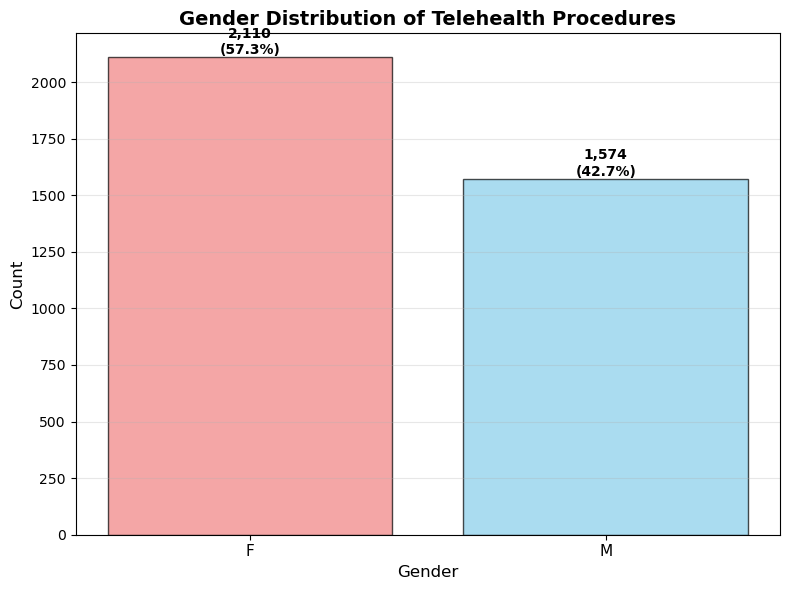

In [185]:
# Gender Distribution Chart
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Gender histogram/proportion
if gender_col:
    gender_counts = telehealth_with_patient[gender_col].value_counts()
    gender_proportions = telehealth_with_patient[gender_col].value_counts(normalize=True) * 100
    
    # Sort by count for better visualization
    gender_counts = gender_counts.sort_values(ascending=False)
    gender_proportions = gender_proportions[gender_counts.index]
    
    # Create color mapping
    colors = {'F': 'lightcoral', 'M': 'skyblue', 'Male': 'skyblue', 'Female': 'lightcoral'}
    bar_colors = [colors.get(g, 'lightgreen') for g in gender_counts.index]
    
    bars = ax.bar(range(len(gender_counts)), gender_counts.values, color=bar_colors, edgecolor='black', alpha=0.7)
    ax.set_xticks(range(len(gender_counts)))
    ax.set_xticklabels(gender_counts.index, fontsize=11)
    ax.set_xlabel('Gender', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Gender Distribution of Telehealth Procedures', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for i, (gender, count) in enumerate(gender_counts.items()):
        pct = gender_proportions[gender]
        ax.text(i, count, f'{count:,}\n({pct:.1f}%)', 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    print("Gender Proportions:")
    for gender, pct in gender_proportions.items():
        print(f"  {gender}: {pct:.2f}%")
else:
    ax.text(0.5, 0.5, 'Gender column not found', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.set_title('Gender Distribution', fontsize=14)

plt.tight_layout()
plt.show()



Age Statistics:
  Total records with age: 3,565
  Mean: 68.11 years
  Median: 70.00 years
  Min: 1.00 years
  Max: 90.00 years
  Standard Deviation: 13.26 years

Age Group Distribution:
  0-18: 26 (0.7%)
  19-30: 37 (1.0%)
  31-40: 90 (2.5%)
  41-50: 186 (5.2%)
  51-60: 464 (13.0%)
  61-70: 1,001 (28.1%)
  71-80: 1,171 (32.8%)
  80+: 590 (16.5%)


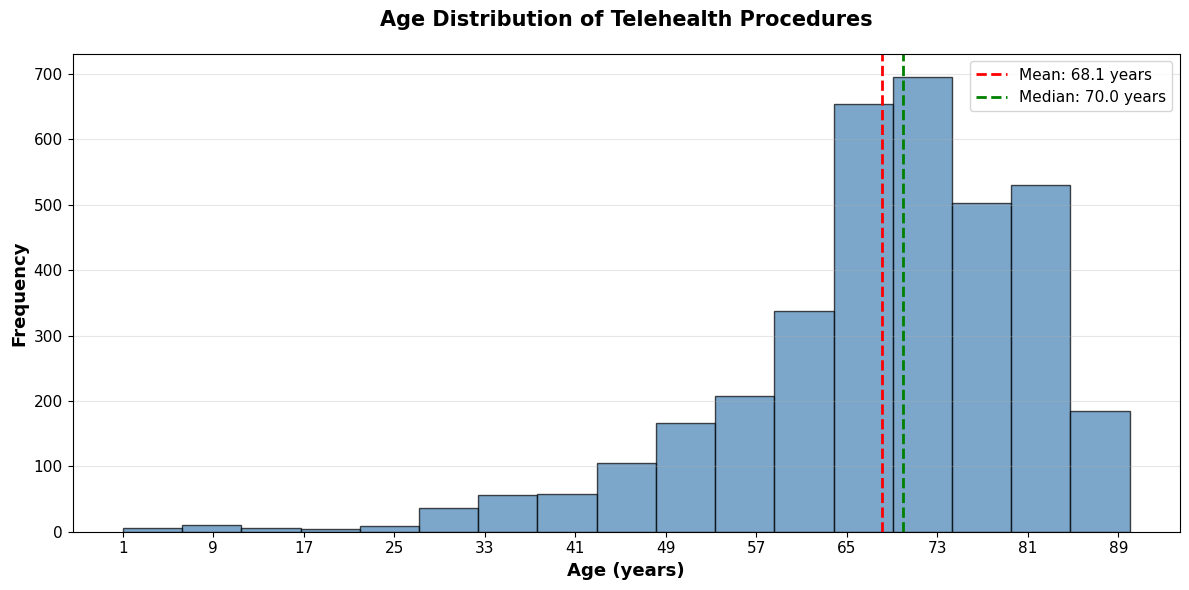

In [186]:
# Age Distribution Graph
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

if 'age' in telehealth_with_patient.columns:
    age_data = telehealth_with_patient['age'].dropna()
    if len(age_data) > 0:
        # Create histogram with better binning
        # Use age range to determine appropriate bins
        age_min = int(age_data.min())
        age_max = int(age_data.max())
        num_bins = min(20, max(10, (age_max - age_min) // 5))  # Adaptive binning
        
        n, bins, patches = ax.hist(age_data, bins=num_bins, color='steelblue', edgecolor='black', alpha=0.7)
        
        # Add statistics lines
        mean_age = age_data.mean()
        median_age = age_data.median()
        ax.axvline(mean_age, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_age:.1f} years')
        ax.axvline(median_age, color='green', linestyle='--', linewidth=2, label=f'Median: {median_age:.1f} years')
        
        # Formatting - improved x-axis
        ax.set_xlabel('Age (years)', fontsize=13, fontweight='bold')
        ax.set_ylabel('Frequency', fontsize=13, fontweight='bold')
        ax.set_title('Age Distribution of Telehealth Procedures', fontsize=15, fontweight='bold', pad=20)
        ax.grid(axis='y', alpha=0.3)
        ax.legend(fontsize=11, loc='upper right')
        
        # Improve x-axis ticks
        ax.tick_params(axis='x', labelsize=11)
        ax.tick_params(axis='y', labelsize=11)
        
        # Set x-axis to show integer ages
        ax.set_xticks(range(int(age_min), int(age_max) + 1, max(1, (int(age_max) - int(age_min)) // 10)))
        
        # Print statistics
        print("Age Statistics:")
        print(f"  Total records with age: {len(age_data):,}")
        print(f"  Mean: {mean_age:.2f} years")
        print(f"  Median: {median_age:.2f} years")
        print(f"  Min: {age_data.min():.2f} years")
        print(f"  Max: {age_data.max():.2f} years")
        print(f"  Standard Deviation: {age_data.std():.2f} years")
        
        # Age groups distribution
        age_groups = pd.cut(age_data, bins=[0, 18, 30, 40, 50, 60, 70, 80, 100], 
                           labels=['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+'])
        print(f"\nAge Group Distribution:")
        for group, count in age_groups.value_counts().sort_index().items():
            pct = count / len(age_data) * 100
            print(f"  {group}: {count:,} ({pct:.1f}%)")
    else:
        ax.text(0.5, 0.5, 'No age data available', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title('Age Distribution', fontsize=14)
else:
    ax.text(0.5, 0.5, 'Age column not found', 
            ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.set_title('Age Distribution', fontsize=14)

plt.tight_layout()
plt.show()


Filtered out 'Telehealth Facility Fee'
Records before filtering: 3,856
Records after filtering: 3,856

Telehealth Type by Sex:

Telephone (Audio-Only) E/M:
  F: 1,218 (58.1%)
  M: 879 (41.9%)
  Total: 2,097

Telehealth Facility Fee (indicative of Telehealth):
  F: 655 (57.9%)
  M: 476 (42.1%)
  Total: 1,131

Video-Supported Telehealth:
  F: 85 (53.8%)
  M: 73 (46.2%)
  Total: 158

Virtual Check-In:
  F: 47 (58.8%)
  M: 33 (41.2%)
  Total: 80

Online Digital Visit (E-Visit):
  F: 34 (68.0%)
  M: 16 (32.0%)
  Total: 50

Interprofessional Consult (EHR/written):
  F: 21 (43.8%)
  M: 27 (56.2%)
  Total: 48

Remote Physiologic Monitoring (RPM):
  F: 3 (7.0%)
  M: 40 (93.0%)
  Total: 43

Interprofessional Consult (Phone/Internet/EHR):
  F: 18 (43.9%)
  M: 23 (56.1%)
  Total: 41

Telephone (Audio-Only) – Clinical Staff:
  F: 27 (84.4%)
  M: 5 (15.6%)
  Total: 32

Interprofessional Consult (coordination):
  F: 2 (50.0%)
  M: 2 (50.0%)
  Total: 4

Overall Summary:
sex                            

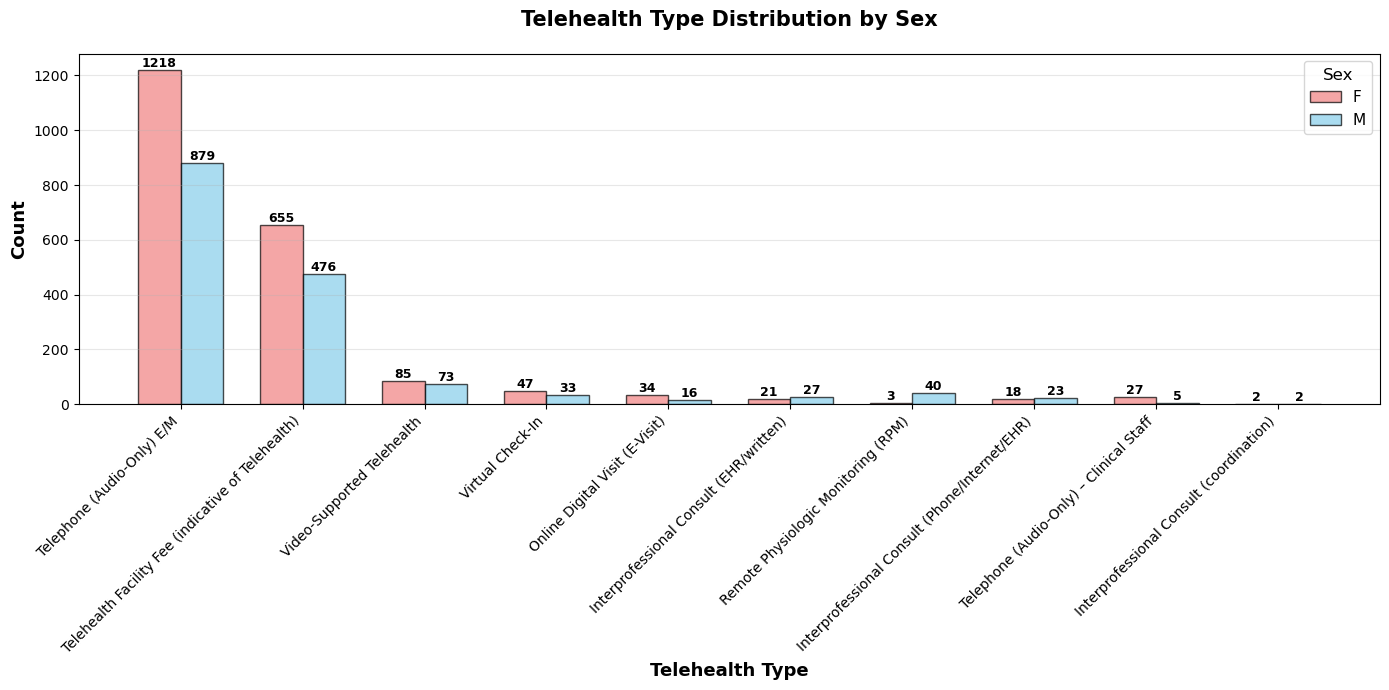

In [187]:
# Telehealth Type by Sex
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# Check if we have the required columns
if 'telehealth_type' in telehealth_with_patient.columns and gender_col:
    # Filter out "Telehealth Facility Fee"
    filtered_data = telehealth_with_patient[
        telehealth_with_patient['telehealth_type'] != 'Telehealth Facility Fee'
    ].copy()
    
    print(f"Filtered out 'Telehealth Facility Fee'")
    print(f"Records before filtering: {len(telehealth_with_patient):,}")
    print(f"Records after filtering: {len(filtered_data):,}")
    print()
    
    # Create cross-tabulation
    crosstab = pd.crosstab(filtered_data['telehealth_type'], 
                           filtered_data[gender_col])
    
    # Sort by total count
    crosstab['Total'] = crosstab.sum(axis=1)
    crosstab = crosstab.sort_values('Total', ascending=False).drop('Total', axis=1)
    
    # Create grouped bar chart
    x = np.arange(len(crosstab.index))
    width = 0.35
    
    # Get colors for genders
    gender_colors = {'F': 'lightcoral', 'M': 'skyblue', 'Female': 'lightcoral', 'Male': 'skyblue'}
    colors_list = [gender_colors.get(col, 'lightgreen') for col in crosstab.columns]
    
    bars = []
    for i, (gender, color) in enumerate(zip(crosstab.columns, colors_list)):
        offset = (i - len(crosstab.columns)/2 + 0.5) * width
        bar = ax.bar(x + offset, crosstab[gender], width, 
                    label=gender, color=color, edgecolor='black', alpha=0.7)
        bars.append(bar)
        
        # Add value labels on bars
        for rect in bar:
            height = rect.get_height()
            if height > 0:
                ax.text(rect.get_x() + rect.get_width()/2., height,
                       f'{int(height)}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Formatting
    ax.set_xlabel('Telehealth Type', fontsize=13, fontweight='bold')
    ax.set_ylabel('Count', fontsize=13, fontweight='bold')
    ax.set_title('Telehealth Type Distribution by Sex', fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(crosstab.index, rotation=45, ha='right', fontsize=10)
    ax.legend(title='Sex', fontsize=11, title_fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    
    # Print statistics
    print("Telehealth Type by Sex:")
    print("=" * 60)
    for telehealth_type in crosstab.index:
        print(f"\n{telehealth_type}:")
        total = crosstab.loc[telehealth_type].sum()
        for gender in crosstab.columns:
            count = crosstab.loc[telehealth_type, gender]
            pct = (count / total * 100) if total > 0 else 0
            print(f"  {gender}: {count:,} ({pct:.1f}%)")
        print(f"  Total: {total:,}")
    
    print(f"\n{'=' * 60}")
    print("Overall Summary:")
    print(crosstab)
    
else:
    ax.text(0.5, 0.5, 'Missing required columns:\n- telehealth_type\n- sex/gender', 
            ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.set_title('Telehealth Type by Sex', fontsize=14)

plt.tight_layout()
plt.show()


1. TEMPORAL ANALYSIS - Telehealth Trends Over Time

📅 Monthly Telehealth Procedure Counts by Type:
telehealth_type  Interprofessional Consult (EHR/written)  \
date_parsed                                                
2015-09                                                0   
2015-10                                                0   
2015-11                                                0   
2015-12                                                0   
2016-01                                                0   
2016-02                                                0   
2016-03                                                0   
2017-02                                                0   
2017-04                                                0   
2017-05                                                0   

telehealth_type  Interprofessional Consult (Phone/Internet/EHR)  \
date_parsed                                                       
2015-09                                       

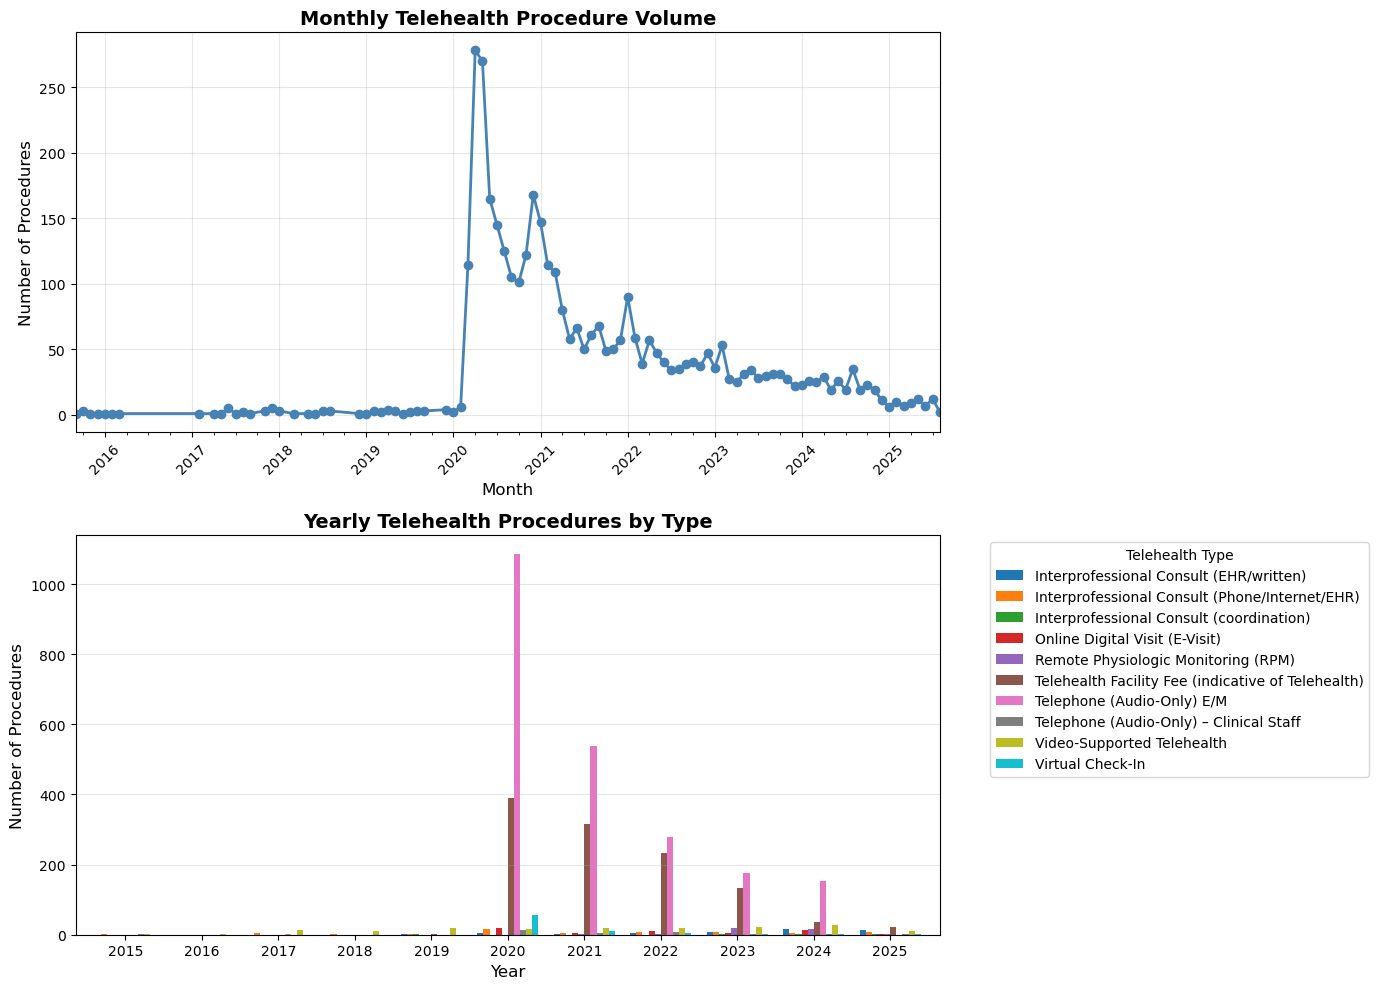

In [188]:
# 1. TEMPORAL ANALYSIS - Trends over time
print("=" * 80)
print("1. TEMPORAL ANALYSIS - Telehealth Trends Over Time")
print("=" * 80)

if 'date' in telehealth_with_patient.columns:
    # Convert date to datetime
    telehealth_with_patient['date_parsed'] = pd.to_datetime(telehealth_with_patient['date'], errors='coerce')
    
    # Monthly trends
    monthly_counts = telehealth_with_patient.groupby([
        telehealth_with_patient['date_parsed'].dt.to_period('M'),
        'telehealth_type'
    ]).size().unstack(fill_value=0)
    
    print("\n📅 Monthly Telehealth Procedure Counts by Type:")
    print(monthly_counts.head(10))
    
    # Overall monthly trend
    monthly_total = telehealth_with_patient.groupby(
        telehealth_with_patient['date_parsed'].dt.to_period('M')
    ).size()
    
    print(f"\n📈 Overall Monthly Trend:")
    print(f"   Peak month: {monthly_total.idxmax()} with {monthly_total.max():,} procedures")
    print(f"   Lowest month: {monthly_total.idxmin()} with {monthly_total.min():,} procedures")
    
    # Yearly trends
    yearly_counts = telehealth_with_patient.groupby([
        telehealth_with_patient['date_parsed'].dt.year,
        'telehealth_type'
    ]).size().unstack(fill_value=0)
    
    print(f"\n📊 Yearly Trends by Telehealth Type:")
    print(yearly_counts)
    
    # Create visualization
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Monthly trend line
    monthly_total.plot(kind='line', ax=axes[0], marker='o', color='steelblue', linewidth=2)
    axes[0].set_title('Monthly Telehealth Procedure Volume', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Month', fontsize=12)
    axes[0].set_ylabel('Number of Procedures', fontsize=12)
    axes[0].grid(alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Yearly breakdown by type
    yearly_counts.plot(kind='bar', ax=axes[1], stacked=False, width=0.8)
    axes[1].set_title('Yearly Telehealth Procedures by Type', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Year', fontsize=12)
    axes[1].set_ylabel('Number of Procedures', fontsize=12)
    axes[1].legend(title='Telehealth Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Date column not available for temporal analysis")


2. PROVIDER TYPE ANALYSIS

👨‍⚕️ Provider Type by Telehealth Type:
telehealth_type               Interprofessional Consult (EHR/written)  \
provider_type                                                           
Device supply                                                       0   
Facility                                                            0   
Non-physician/clinical staff                                        0   
PT/OT/SLP                                                           0   
Physician                                                           0   
Physician/QHP                                                       0   
Provider-to-provider                                               51   

telehealth_type               Interprofessional Consult (Phone/Internet/EHR)  \
provider_type                                                                  
Device supply                                                              0   
Facility                            

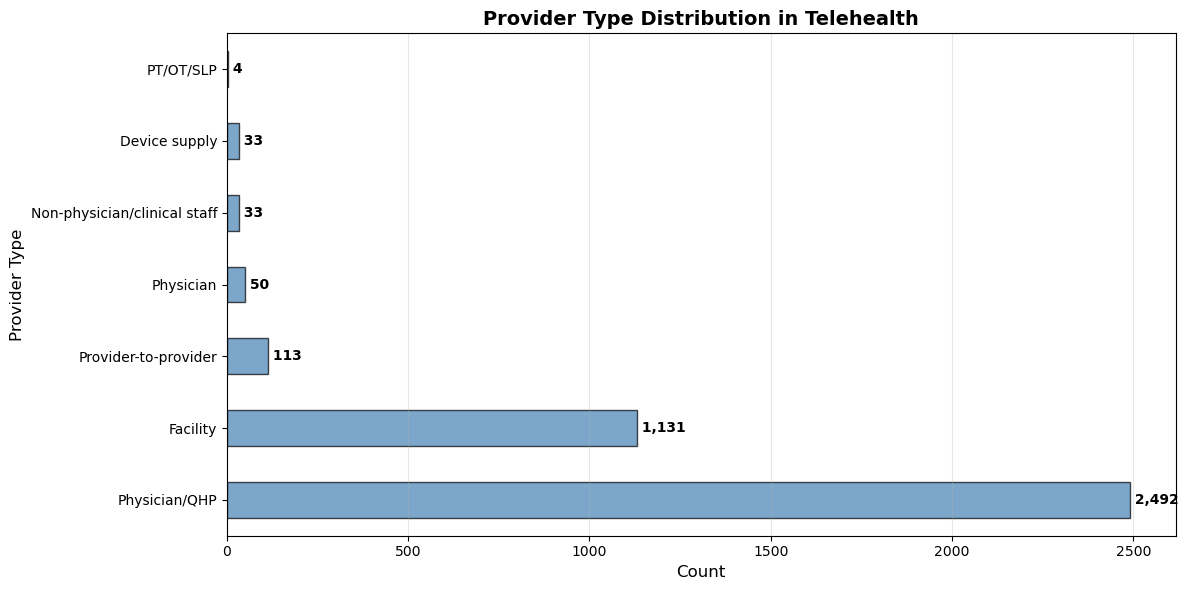

In [189]:
# 2. PROVIDER TYPE ANALYSIS
print("=" * 80)
print("2. PROVIDER TYPE ANALYSIS")
print("=" * 80)

if 'provider_type' in telehealth_with_patient.columns:
    provider_analysis = telehealth_with_patient.groupby(['provider_type', 'telehealth_type']).size().unstack(fill_value=0)
    
    print("\n👨‍⚕️ Provider Type by Telehealth Type:")
    print(provider_analysis)
    
    # Provider type distribution
    provider_counts = telehealth_with_patient['provider_type'].value_counts()
    provider_pct = telehealth_with_patient['provider_type'].value_counts(normalize=True) * 100
    
    print(f"\n📊 Overall Provider Type Distribution:")
    for provider, count in provider_counts.items():
        pct = provider_pct[provider]
        print(f"   {provider:<30} {count:>6,} ({pct:>5.2f}%)")
    
    # Visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    provider_counts.plot(kind='barh', ax=ax, color='steelblue', edgecolor='black', alpha=0.7)
    ax.set_title('Provider Type Distribution in Telehealth', fontsize=14, fontweight='bold')
    ax.set_xlabel('Count', fontsize=12)
    ax.set_ylabel('Provider Type', fontsize=12)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (provider, count) in enumerate(provider_counts.items()):
        ax.text(count, i, f' {count:,}', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Provider type column not available")


3. PATIENT UTILIZATION PATTERNS

👥 Patient Telehealth Utilization:
   Total unique patients: 1,221
   Patients with 1 visit: 556
   Patients with 2-5 visits: 501
   Patients with 6-10 visits: 107
   Patients with 11+ visits: 57
   Max visits by single patient: 63

   Average telehealth visits per patient: 3.16

🏆 Top 10 Patients by Telehealth Usage:
   Patient NgJDB: 63 telehealth visits
   Patient WA0QE: 52 telehealth visits
   Patient WgVAD: 48 telehealth visits
   Patient NwFlB: 46 telehealth visits
   Patient NAIjB: 44 telehealth visits
   Patient NwHj: 37 telehealth visits
   Patient MBKfF: 37 telehealth visits
   Patient 2wrzC: 33 telehealth visits
   Patient SQx5D: 32 telehealth visits
   Patient NghrB: 25 telehealth visits


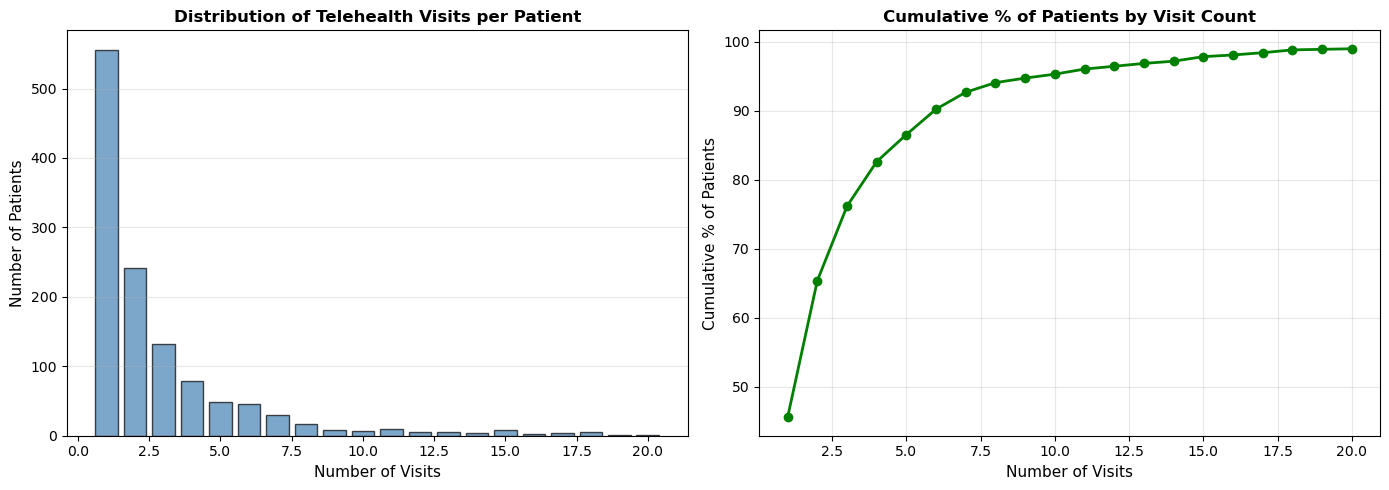

In [190]:
# 3. PATIENT UTILIZATION PATTERNS
print("=" * 80)
print("3. PATIENT UTILIZATION PATTERNS")
print("=" * 80)

if 'patient_id' in telehealth_with_patient.columns:
    # Patients with multiple telehealth visits
    patient_visit_counts = telehealth_with_patient['patient_id'].value_counts()
    
    print(f"\n👥 Patient Telehealth Utilization:")
    print(f"   Total unique patients: {len(patient_visit_counts):,}")
    print(f"   Patients with 1 visit: {(patient_visit_counts == 1).sum():,}")
    print(f"   Patients with 2-5 visits: {((patient_visit_counts >= 2) & (patient_visit_counts <= 5)).sum():,}")
    print(f"   Patients with 6-10 visits: {((patient_visit_counts >= 6) & (patient_visit_counts <= 10)).sum():,}")
    print(f"   Patients with 11+ visits: {(patient_visit_counts >= 11).sum():,}")
    print(f"   Max visits by single patient: {patient_visit_counts.max():,}")
    
    # Average visits per patient
    avg_visits = patient_visit_counts.mean()
    print(f"\n   Average telehealth visits per patient: {avg_visits:.2f}")
    
    # Top telehealth users
    print(f"\n🏆 Top 10 Patients by Telehealth Usage:")
    for patient_id, count in patient_visit_counts.head(10).items():
        print(f"   Patient {patient_id}: {count} telehealth visits")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Distribution of visit counts
    visit_distribution = patient_visit_counts.value_counts().sort_index()
    axes[0].bar(visit_distribution.index[:20], visit_distribution.values[:20], 
                color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].set_title('Distribution of Telehealth Visits per Patient', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Number of Visits', fontsize=11)
    axes[0].set_ylabel('Number of Patients', fontsize=11)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Cumulative percentage
    cumulative_pct = (patient_visit_counts.value_counts().sort_index().cumsum() / len(patient_visit_counts) * 100)[:20]
    axes[1].plot(cumulative_pct.index, cumulative_pct.values, marker='o', linewidth=2, color='green')
    axes[1].set_title('Cumulative % of Patients by Visit Count', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Number of Visits', fontsize=11)
    axes[1].set_ylabel('Cumulative % of Patients', fontsize=11)
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Patient ID column not available")


6. AGE AND GENDER CROSS-ANALYSIS

👥 Age Group by Gender:
sex           F     M   All
age_group                  
0-18          2    24    26
19-30        29     7    36
31-40        64    25    89
41-50       106    79   185
51-60       249   204   453
61-70       575   386   961
71-80       590   517  1107
80+         300   249   549
All        1915  1491  3406

📊 Age Group by Telehealth Type:
telehealth_type  Interprofessional Consult (EHR/written)  \
age_group                                                  
0-18                                                   1   
19-30                                                  0   
31-40                                                  1   
41-50                                                  0   
51-60                                                  5   
61-70                                                 12   
71-80                                                 19   
80+                                                   12   

t

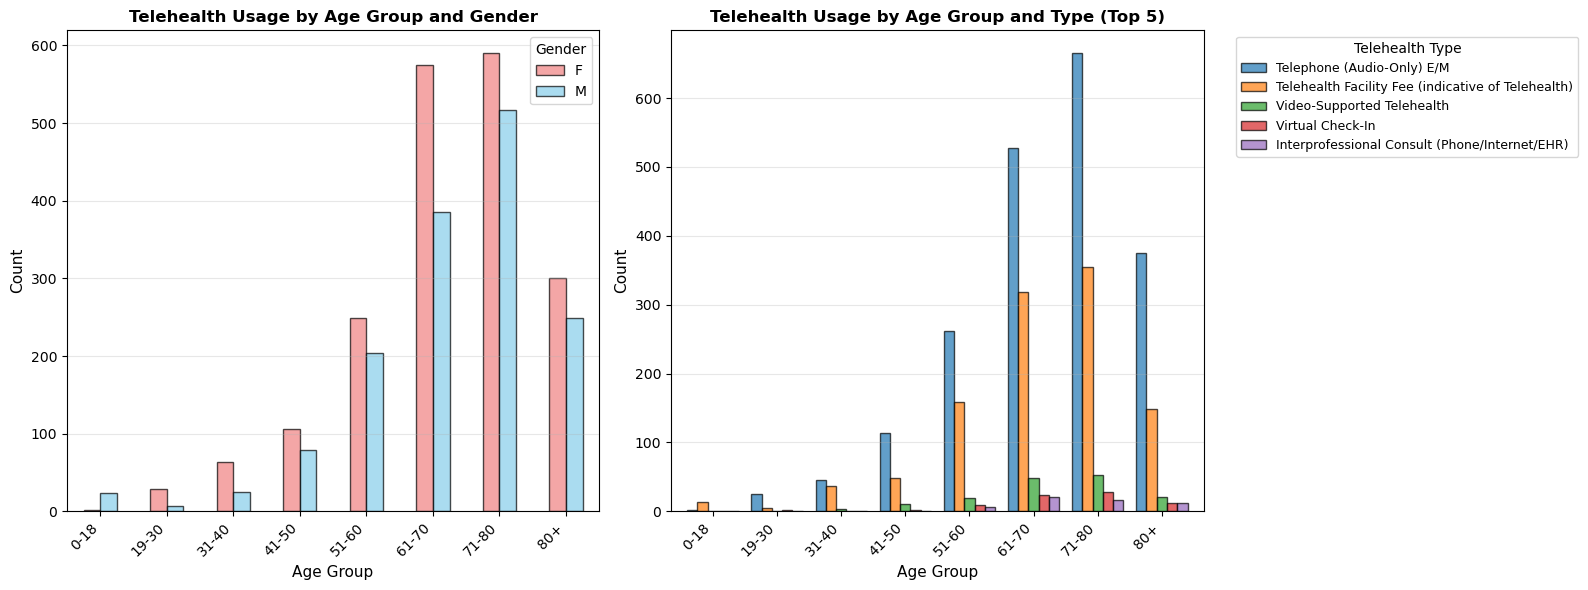

In [191]:
# 6. AGE AND GENDER CROSS-ANALYSIS
print("=" * 80)
print("6. AGE AND GENDER CROSS-ANALYSIS")
print("=" * 80)

if 'age' in telehealth_with_patient.columns and gender_col:
    # Age groups by gender
    telehealth_with_patient['age_group'] = pd.cut(
        telehealth_with_patient['age'], 
        bins=[0, 18, 30, 40, 50, 60, 70, 80, 100],
        labels=['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+']
    )
    
    age_gender_cross = pd.crosstab(
        telehealth_with_patient['age_group'],
        telehealth_with_patient[gender_col],
        margins=True
    )
    
    print("\n👥 Age Group by Gender:")
    print(age_gender_cross)
    
    # Age group by telehealth type
    age_type_cross = pd.crosstab(
        telehealth_with_patient['age_group'],
        telehealth_with_patient['telehealth_type']
    )
    
    print(f"\n📊 Age Group by Telehealth Type:")
    print(age_type_cross)
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Age group by gender
    age_gender_cross.drop('All').drop('All', axis=1).plot(kind='bar', ax=axes[0], 
                                                          color=['lightcoral', 'skyblue'], 
                                                          edgecolor='black', alpha=0.7)
    axes[0].set_title('Telehealth Usage by Age Group and Gender', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Age Group', fontsize=11)
    axes[0].set_ylabel('Count', fontsize=11)
    axes[0].legend(title='Gender', fontsize=10)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Age group by telehealth type (top 5 types)
    top_types = telehealth_with_patient['telehealth_type'].value_counts().head(5).index
    age_type_filtered = age_type_cross[top_types]
    age_type_filtered.plot(kind='bar', ax=axes[1], stacked=False, width=0.8, edgecolor='black', alpha=0.7)
    axes[1].set_title('Telehealth Usage by Age Group and Type (Top 5)', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Age Group', fontsize=11)
    axes[1].set_ylabel('Count', fontsize=11)
    axes[1].legend(title='Telehealth Type', fontsize=9, bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Age or gender columns not available")


✅ patient_id found. Non-null values: 3,359,647
Selected patient: NgJDB
  Telehealth visits: 67
  Other visits: 857


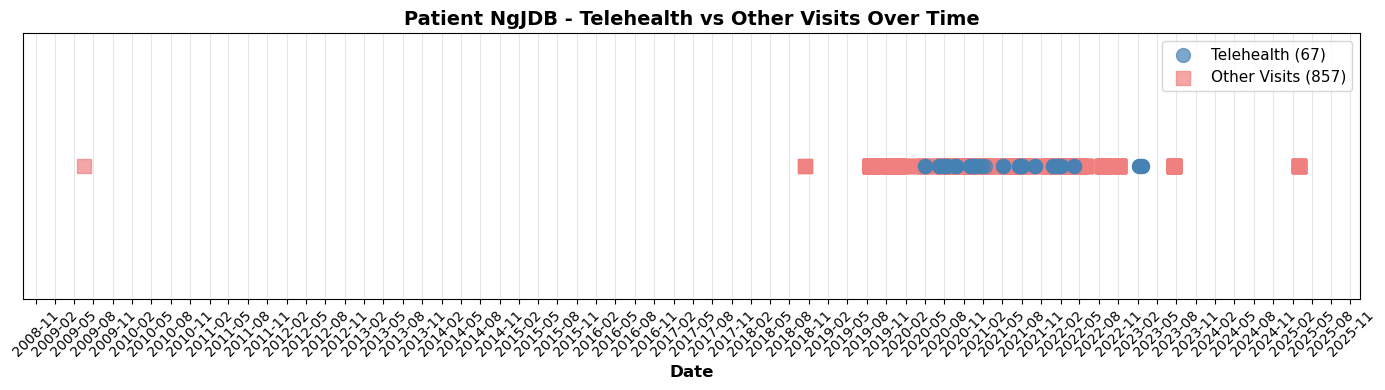


📊 Visit Summary:
   Date range: 2009-06-19 00:00:00 to 2025-03-03 00:00:00
   Total visits: 924
   Telehealth: 67 (7.3%)
   Other: 857 (92.7%)


In [192]:
# Plot one patient's telehealth vs other visits over time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Merge procedure with encounter to get dates (procedure already has patient_id)
procedure_with_enc = procedure.merge(
    encounter[['encounter_id', 'start_date', 'type']],
    on='encounter_id',
    how='left'
)

# Verify patient_id exists
if 'patient_id' not in procedure_with_enc.columns:
    print("ERROR: patient_id not found after merge!")
    print("Available columns:", procedure_with_enc.columns.tolist())
else:
    print(f"✅ patient_id found. Non-null values: {procedure_with_enc['patient_id'].notna().sum():,}")

# Convert dates
procedure_with_enc['start_date'] = pd.to_datetime(procedure_with_enc['start_date'], errors='coerce')

# Identify telehealth procedures
procedure_with_enc['is_telehealth'] = procedure_with_enc['procedure_code'].astype(str).str.upper().isin(
    [code.upper() for code in telehealth_map.keys()]
)

# Find patients with both types of visits
patients_with_both = procedure_with_enc.groupby('patient_id').agg({
    'is_telehealth': ['sum', lambda x: (~x).sum()]
}).reset_index()
patients_with_both.columns = ['patient_id', 'telehealth_count', 'other_count']
patients_with_both = patients_with_both[
    (patients_with_both['telehealth_count'] > 0) & 
    (patients_with_both['other_count'] > 0) &
    (patients_with_both['patient_id'].notna())
].sort_values('telehealth_count', ascending=False)

if len(patients_with_both) > 0:
    # Select patient with most telehealth visits
    selected_patient = patients_with_both.iloc[0]['patient_id']
    print(f"Selected patient: {selected_patient}")
    print(f"  Telehealth visits: {patients_with_both.iloc[0]['telehealth_count']}")
    print(f"  Other visits: {patients_with_both.iloc[0]['other_count']}")
    
    # Filter for this patient
    patient_data = procedure_with_enc[
        (procedure_with_enc['patient_id'] == selected_patient) &
        (procedure_with_enc['start_date'].notna())
    ].copy()
    
    # Separate telehealth and other visits
    telehealth_visits = patient_data[patient_data['is_telehealth'] == True]
    other_visits = patient_data[patient_data['is_telehealth'] == False]
    
    # Create plot - single timeline
    fig, ax = plt.subplots(1, 1, figsize=(14, 4))
    
    # Plot telehealth visits on single line
    if len(telehealth_visits) > 0:
        ax.scatter(telehealth_visits['start_date'], 
                  [0] * len(telehealth_visits),
                  color='steelblue', s=100, alpha=0.7, 
                  label=f'Telehealth ({len(telehealth_visits)})', marker='o', zorder=3)
    
    # Plot other visits on same line
    if len(other_visits) > 0:
        ax.scatter(other_visits['start_date'], 
                  [0] * len(other_visits),
                  color='lightcoral', s=100, alpha=0.7, 
                  label=f'Other Visits ({len(other_visits)})', marker='s', zorder=2)
    
    # Formatting
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_title(f'Patient {selected_patient} - Telehealth vs Other Visits Over Time', 
                fontsize=14, fontweight='bold')
    ax.set_yticks([])  # Remove y-axis ticks
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(axis='x', alpha=0.3)
    
    # Format x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n📊 Visit Summary:")
    print(f"   Date range: {patient_data['start_date'].min()} to {patient_data['start_date'].max()}")
    print(f"   Total visits: {len(patient_data)}")
    print(f"   Telehealth: {len(telehealth_visits)} ({len(telehealth_visits)/len(patient_data)*100:.1f}%)")
    print(f"   Other: {len(other_visits)} ({len(other_visits)/len(patient_data)*100:.1f}%)")
else:
    print("No patients found with both telehealth and other visits")


In [193]:
# === Stroke-Related Diagnosis & Procedure Codes ===
# ICD-10-CM, ICD-9-CM, and ICD-10-PCS sets for ischemic, hemorrhagic, TIA, sequelae, and treatments.

stroke_icd_map = {
    # 1) Acute Ischemic Stroke (ICD-10-CM)
    "ischemic_stroke_icd10": {
        "codes": [
            "I63",  # Cerebral infarction
            "I63.0","I63.1","I63.2","I63.3","I63.4","I63.5","I63.6","I63.8","I63.9",
        ],
        "description": "Acute ischemic stroke / cerebral infarction (thrombotic, embolic, or unspecified)",
    },

    # 2) Hemorrhagic Stroke (ICD-10-CM)
    "hemorrhagic_stroke_icd10": {
        "codes": [
            "I60",  # Subarachnoid hemorrhage
            "I61",  # Intracerebral hemorrhage
            "I62",  # Other and unspecified nontraumatic intracranial hemorrhage
            "I60.9","I61.9","I62.9",
        ],
        "description": "Nontraumatic subarachnoid, intracerebral, or other intracranial hemorrhage",
    },

    # 3) Unspecified Stroke (ICD-10-CM)
    "unspecified_stroke_icd10": {
        "codes": ["I64"],
        "description": "Stroke, not specified as hemorrhage or infarction",
    },

    # 4) Transient Ischemic Attack (ICD-10-CM)
    "tia_icd10": {
        "codes": ["G45.9"],
        "description": "Transient cerebral ischemic attack, unspecified",
    },

    # 5) Sequelae / Late Effects of Stroke (ICD-10-CM)
    "stroke_sequelae_icd10": {
        "codes": [
            "I69","I69.0","I69.1","I69.2","I69.3","I69.4","I69.5","I69.8","I69.9",
        ],
        "description": "Sequelae of cerebrovascular disease (e.g., hemiplegia, aphasia, dysphagia)",
    },

    # 6) Occlusion/Stenosis (without infarction)
    "occlusion_stenosis_icd10": {
        "codes": [
            "I65","I65.2","I65.3","I65.8","I66","I66.9",
        ],
        "description": "Occlusion and stenosis of precerebral/cerebral arteries without infarction",
    },

    # 7) ICD-9-CM Stroke Diagnoses (legacy)
    "stroke_icd9": {
        "codes": [
            # Hemorrhagic
            "430","431","432","432.0","432.1","432.9",
            # Ischemic
            "433.01","433.11","433.21","433.31","433.81","433.91",
            "434.01","434.11","434.91","436",
            # TIA
            "435.0","435.1","435.2","435.3","435.8","435.9",
            # Late Effects
            "438.0","438.1","438.2","438.3","438.4","438.5","438.6","438.7","438.8","438.9",
        ],
        "description": "ICD-9-CM cerebrovascular diseases (for pre-2015 data)",
    },

    # 8️) ICD-10-PCS Stroke Procedures (inpatient treatments)
    "stroke_procedure_icd10pcs": {
        "codes": [
            # Mechanical thrombectomy (removal of clot)
            "03CG3ZZ","03CH3ZZ","03CJ3ZZ","03CK3ZZ",
            # Carotid endarterectomy
            "03CJ0ZZ",
            # Intracranial aneurysm clipping or coiling
            "03VG0ZZ","03VG3DZ",
            # Thrombolytic administration (tPA)
            "3E03317","3E04317",
            # Decompressive craniectomy
            "00B70ZZ","00B80ZZ",
        ],
        "description": "ICD-10-PCS procedures for mechanical thrombectomy, tPA, aneurysm clipping, and decompression",
    },

    # 9️) CPT/HCPCS Stroke Treatment Procedures (outpatient/claims)
    "stroke_cpt_hcpcs": {
        "codes": [
            "37215","37216",  # Carotid artery stent
            "61645",          # Mechanical thrombectomy
            "J2997",          # Alteplase (tPA) injection
        ],
        "description": "CPT/HCPCS procedure codes for carotid stenting, thrombectomy, and tPA",
    },
}



In [ ]:
# Count stroke patients using comprehensive stroke code map
print("=" * 80)
print("STROKE PATIENT COUNT - USING COMPREHENSIVE CODE MAP")
print("=" * 80)

# Collect all stroke codes from the map
all_stroke_codes = set()
for category, data in stroke_icd_map.items():
    all_stroke_codes.update([code.upper() for code in data['codes']])

print(f"\n📋 Total unique stroke codes in map: {len(all_stroke_codes)}")
print(f"   Categories: {len(stroke_icd_map)}")

# Check diagnosis table
if 'diagnosis' in loaded_tables:
    diagnosis = loaded_tables['diagnosis']
    
    # Get diagnosis code column name
    diag_code_col = None
    for col in diagnosis.columns:
        if 'diagnosis_code' in col.lower():
            diag_code_col = col
            break
    
    if diag_code_col:
        # Find stroke diagnoses - exact match and prefix match
        diagnosis_codes_upper = diagnosis[diag_code_col].astype(str).str.upper().str.strip()
        
        # Check for exact matches
        exact_matches = diagnosis_codes_upper.isin(all_stroke_codes)
        
        # Check for codes that start with stroke codes (e.g., I63.0 matches I63)
        prefix_matches = diagnosis_codes_upper.apply(
            lambda x: any(x.startswith(code) for code in all_stroke_codes)
        )
        
        diagnosis['is_stroke'] = exact_matches | prefix_matches
        
        stroke_diagnoses = diagnosis[diagnosis['is_stroke'] == True]
        stroke_patients = stroke_diagnoses['patient_id'].nunique()
        total_stroke_diagnoses = len(stroke_diagnoses)
        
        print(f"\n📊 Stroke Statistics:")
        print(f"   Total stroke diagnoses: {total_stroke_diagnoses:,}")
        print(f"   Unique stroke patients: {stroke_patients:,}")
        if stroke_patients > 0:
            print(f"   Average diagnoses per patient: {total_stroke_diagnoses/stroke_patients:.2f}")
        
        # Breakdown by stroke category
        print(f"\n📋 Stroke Breakdown by Category:")
        for category, data in stroke_icd_map.items():
            category_codes = [code.upper() for code in data['codes']]
            category_matches = diagnosis_codes_upper.apply(
                lambda x: any(x.startswith(code) or x == code for code in category_codes)
            )
            category_patients = diagnosis[category_matches]['patient_id'].nunique()
            category_diagnoses = category_matches.sum()
            if category_patients > 0:
                print(f"   {category:<30} {category_patients:>6,} patients, {category_diagnoses:>6,} diagnoses")
        
        # Show top stroke codes
        print(f"\n📋 Top 15 Stroke Diagnosis Codes:")
        top_stroke_codes = stroke_diagnoses[diag_code_col].value_counts().head(15)
        for code, count in top_stroke_codes.items():
            print(f"   {code:<15} {count:>6,} diagnoses")
        
        # Check if stroke patients use telehealth
        stroke_patient_ids = set(stroke_diagnoses['patient_id'].unique())
        procedure_stroke = procedure[procedure['patient_id'].isin(stroke_patient_ids)]
        
        procedure_stroke['is_telehealth'] = procedure_stroke['procedure_code'].astype(str).str.upper().isin(
            [code.upper() for code in telehealth_map.keys()]
        )
        
        stroke_telehealth_patients = procedure_stroke[procedure_stroke['is_telehealth'] == True]['patient_id'].nunique()
        stroke_telehealth_count = (procedure_stroke['is_telehealth'] == True).sum()
        
        print(f"\n🏥 Telehealth Usage by Stroke Patients:")
        print(f"   Stroke patients using telehealth: {stroke_telehealth_patients:,} out of {stroke_patients:,}")
        if stroke_patients > 0:
            print(f"   Percentage: {stroke_telehealth_patients/stroke_patients*100:.1f}%")
            print(f"   Total telehealth procedures: {stroke_telehealth_count:,}")
            
    else:
        print("⚠️ Diagnosis code column not found")
        print(f"Available columns: {diagnosis.columns.tolist()}")
else:
    print("⚠️ Diagnosis table not found")

STROKE PATIENT COUNT - USING COMPREHENSIVE CODE MAP

📋 Total unique stroke codes in map: 80
   Categories: 9


In [ ]:

# First, identify stroke patients from diagnosis table
print("Identifying stroke patients...")
if 'diagnosis' in loaded_tables:
    diagnosis = loaded_tables['diagnosis']
    
    # Get diagnosis code column name
    diag_code_col = None
    for col in diagnosis.columns:
        if 'diagnosis_code' in col.lower():
            diag_code_col = col
            break
    
    if diag_code_col:
        # Collect all stroke codes from stroke_icd_map (if it exists)
        if 'stroke_icd_map' in globals():
            all_stroke_codes = set()
            for category, data in stroke_icd_map.items():
                all_stroke_codes.update([code.upper() for code in data['codes']])
            
            # Find stroke diagnoses
            diagnosis_codes_upper = diagnosis[diag_code_col].astype(str).str.upper().str.strip()
            exact_matches = diagnosis_codes_upper.isin(all_stroke_codes)
            prefix_matches = diagnosis_codes_upper.apply(
                lambda x: any(x.startswith(code) for code in all_stroke_codes)
            )
            diagnosis['is_stroke'] = exact_matches | prefix_matches
            stroke_patient_ids = set(diagnosis[diagnosis['is_stroke'] == True]['patient_id'].unique())
            print(f"   Found {len(stroke_patient_ids):,} stroke patients")
        else:
            # Fallback: use simple I60-I69 pattern
            stroke_patterns = [f'I6{i}' for i in range(10)]  # I60-I69
            diagnosis['is_stroke'] = diagnosis[diag_code_col].astype(str).str.upper().str.startswith(tuple(stroke_patterns))
            stroke_patient_ids = set(diagnosis[diagnosis['is_stroke'] == True]['patient_id'].unique())
            print(f"   Found {len(stroke_patient_ids):,} stroke patients (using I60-I69 pattern)")
    else:
        print("⚠️ Diagnosis code column not found")
        stroke_patient_ids = set()
else:
    print("⚠️ Diagnosis table not found")
    stroke_patient_ids = set()

# Merge procedure with encounter to get dates (procedure already has patient_id)
procedure_with_enc = procedure.merge(
    encounter[['encounter_id', 'start_date', 'type']],
    on='encounter_id',
    how='left'
)

# Convert dates
procedure_with_enc['start_date'] = pd.to_datetime(procedure_with_enc['start_date'], errors='coerce')

# Identify telehealth procedures
procedure_with_enc['is_telehealth'] = procedure_with_enc['procedure_code'].astype(str).str.upper().isin(
    [code.upper() for code in telehealth_map.keys()]
)

# Find patients with both types of visits
patients_with_both = procedure_with_enc.groupby('patient_id').agg({
    'is_telehealth': ['sum', lambda x: (~x).sum()]
}).reset_index()
patients_with_both.columns = ['patient_id', 'telehealth_count', 'other_count']
patients_with_both = patients_with_both[
    (patients_with_both['telehealth_count'] > 0) & 
    (patients_with_both['other_count'] > 0) &
    (patients_with_both['patient_id'].notna())
].sort_values('telehealth_count', ascending=False)

# Filter to only include stroke patients with at least one telehealth visit
if len(stroke_patient_ids) > 0:
    patients_with_both = patients_with_both[
        patients_with_both['patient_id'].isin(stroke_patient_ids)
    ]
    print(f"   Filtered to {len(patients_with_both):,} stroke patients with both telehealth and other visits")
else:
    print("⚠️ No stroke patients found - showing all patients with both visit types")

if len(patients_with_both) > 0:
    # Randomly select a patient from stroke patients with both visit types
    random_idx = random.randint(0, len(patients_with_both) - 1)
    selected_patient = patients_with_both.iloc[random_idx]['patient_id']
    print(f"\n🎲 Randomly selected patient: {selected_patient}")
    print(f"  Telehealth visits: {patients_with_both.iloc[random_idx]['telehealth_count']}")
    print(f"  Other visits: {patients_with_both.iloc[random_idx]['other_count']}")
    
    # Filter for this patient
    patient_data = procedure_with_enc[
        (procedure_with_enc['patient_id'] == selected_patient) &
        (procedure_with_enc['start_date'].notna())
    ].copy()
    
    # Separate telehealth and other visits
    telehealth_visits = patient_data[patient_data['is_telehealth'] == True]
    other_visits = patient_data[patient_data['is_telehealth'] == False]
    
    # Create plot - single timeline
    fig, ax = plt.subplots(1, 1, figsize=(14, 4))
    
    # Plot telehealth visits on single line
    if len(telehealth_visits) > 0:
        ax.scatter(telehealth_visits['start_date'], 
                  [0] * len(telehealth_visits),
                  color='steelblue', s=100, alpha=0.7, 
                  label=f'Telehealth ({len(telehealth_visits)})', marker='o', zorder=3)
    
    # Plot other visits on same line
    if len(other_visits) > 0:
        ax.scatter(other_visits['start_date'], 
                  [0] * len(other_visits),
                  color='lightcoral', s=100, alpha=0.7, 
                  label=f'Other Visits ({len(other_visits)})', marker='s', zorder=2)
    
    # Formatting
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_title(f'Stroke Patient {selected_patient} - Telehealth vs Other Visits Over Time', 
                fontsize=14, fontweight='bold')
    ax.set_yticks([])  # Remove y-axis ticks
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(axis='x', alpha=0.3)
    
    # Format x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n📊 Visit Summary:")
    print(f"   Date range: {patient_data['start_date'].min()} to {patient_data['start_date'].max()}")
    print(f"   Total visits: {len(patient_data)}")
    print(f"   Telehealth: {len(telehealth_visits)} ({len(telehealth_visits)/len(patient_data)*100:.1f}%)")
    print(f"   Other: {len(other_visits)} ({len(other_visits)/len(patient_data)*100:.1f}%)")
else:
    print("No stroke patients found with both telehealth and other visits")


Identifying stroke patients...


KeyboardInterrupt: 

In [ ]:
# Count patients with telehealth visits AFTER a stroke encounter
print("=" * 80)
print("PATIENTS WITH TELEHEALTH VISITS AFTER STROKE ENCOUNTER")
print("=" * 80)

# Step 1: Identify stroke patients and their first stroke encounter date
print("\n1️⃣ Identifying stroke patients and their first stroke encounter date...")

if 'diagnosis' in loaded_tables and 'encounter' in loaded_tables:
    diagnosis = loaded_tables['diagnosis']
    encounter = loaded_tables['encounter']
    
    # Get diagnosis code column name
    diag_code_col = None
    for col in diagnosis.columns:
        if 'diagnosis_code' in col.lower():
            diag_code_col = col
            break
    
    if diag_code_col:
        # Collect all stroke codes from stroke_icd_map (if it exists)
        if 'stroke_icd_map' in globals():
            all_stroke_codes = set()
            for category, data in stroke_icd_map.items():
                all_stroke_codes.update([code.upper() for code in data['codes']])
            
            # Find stroke diagnoses
            diagnosis_codes_upper = diagnosis[diag_code_col].astype(str).str.upper().str.strip()
            exact_matches = diagnosis_codes_upper.isin(all_stroke_codes)
            prefix_matches = diagnosis_codes_upper.apply(
                lambda x: any(x.startswith(code) for code in all_stroke_codes)
            )
            stroke_diagnoses = diagnosis[exact_matches | prefix_matches].copy()
        else:
            # Fallback: use simple I60-I69 pattern
            stroke_patterns = [f'I6{i}' for i in range(10)]  # I60-I69
            stroke_diagnoses = diagnosis[
                diagnosis[diag_code_col].astype(str).str.upper().str.startswith(tuple(stroke_patterns))
            ].copy()
        
        print(f"   Found {len(stroke_diagnoses):,} stroke diagnoses")
        
        # Get all unique stroke patients first
        all_stroke_patients = stroke_diagnoses['patient_id'].unique()
        print(f"   Total unique stroke patients: {len(all_stroke_patients):,}")
        
        # Merge stroke diagnoses with encounter to get encounter dates
        stroke_with_encounter = stroke_diagnoses.merge(
            encounter[['encounter_id', 'patient_id', 'start_date']],
            on=['encounter_id', 'patient_id'],
            how='left'
        )
        
        # Convert dates
        stroke_with_encounter['start_date'] = pd.to_datetime(
            stroke_with_encounter['start_date'], errors='coerce'
        )
        
        # Get first stroke encounter date per patient (for those with encounter dates)
        first_stroke_encounter = stroke_with_encounter[
            stroke_with_encounter['start_date'].notna()
        ].groupby('patient_id')['start_date'].min().reset_index()
        first_stroke_encounter.columns = ['patient_id', 'first_stroke_date']
        
        patients_with_encounter_dates = len(first_stroke_encounter)
        patients_without_encounter_dates = len(all_stroke_patients) - patients_with_encounter_dates
        
        print(f"   Found {patients_with_encounter_dates:,} patients with stroke encounter dates")
        if patients_without_encounter_dates > 0:
            print(f"   ⚠️ {patients_without_encounter_dates:,} stroke patients have no encounter dates (will be excluded from analysis)")
        
        # For patients without encounter dates, try to use diagnosis date if available
        # Check if diagnosis table has a date column
        diag_date_col = None
        for col in diagnosis.columns:
            if 'date' in col.lower() and 'diagnosis' not in col.lower():
                diag_date_col = col
                break
        
        if diag_date_col and patients_without_encounter_dates > 0:
            print(f"   Trying to use diagnosis date column '{diag_date_col}' for remaining patients...")
            stroke_with_diag_date = stroke_diagnoses[
                ~stroke_diagnoses['patient_id'].isin(first_stroke_encounter['patient_id'])
            ].copy()
            
            if diag_date_col in stroke_with_diag_date.columns:
                stroke_with_diag_date[diag_date_col] = pd.to_datetime(
                    stroke_with_diag_date[diag_date_col], errors='coerce'
                )
                
                first_stroke_from_diag = stroke_with_diag_date[
                    stroke_with_diag_date[diag_date_col].notna()
                ].groupby('patient_id')[diag_date_col].min().reset_index()
                first_stroke_from_diag.columns = ['patient_id', 'first_stroke_date']
                
                # Combine both sources
                first_stroke_encounter = pd.concat([
                    first_stroke_encounter,
                    first_stroke_from_diag
                ], ignore_index=True)
                
                print(f"   ✅ Added {len(first_stroke_from_diag):,} patients using diagnosis dates")
                print(f"   Total patients with stroke dates: {len(first_stroke_encounter):,}")
        
        # Step 2: Identify telehealth procedures
        print("\n2️⃣ Identifying telehealth procedures...")
        
        # Procedure table already has patient_id, just need start_date from encounter
        print("   Merging procedure with encounter to get start_date...")
        procedure_with_enc = procedure.merge(
            encounter[['encounter_id', 'start_date']],
            on='encounter_id',
            how='left'
        )
        
        print(f"   ✅ Merged procedure with encounter")
        print(f"   patient_id from procedure table: {'patient_id' in procedure_with_enc.columns}")
        
        # Convert dates
        procedure_with_enc['start_date'] = pd.to_datetime(
            procedure_with_enc['start_date'], errors='coerce'
        )
        
        # Mark telehealth procedures
        procedure_with_enc['is_telehealth'] = procedure_with_enc['procedure_code'].astype(str).str.upper().isin(
            [code.upper() for code in telehealth_map.keys()]
        )
        
        # Filter for telehealth procedures with both patient_id and date
        telehealth_procedures = procedure_with_enc[
            (procedure_with_enc['is_telehealth'] == True) &
            (procedure_with_enc['start_date'].notna()) &
            (procedure_with_enc['patient_id'].notna())
        ].copy()
        
        print(f"   Found {len(telehealth_procedures):,} telehealth procedures with dates and patient_id")
        
        # Verify columns
        if 'patient_id' not in telehealth_procedures.columns:
            print("   ❌ ERROR: patient_id column missing after merge!")
            print(f"   Available columns: {telehealth_procedures.columns.tolist()}")
        else:
            print(f"   ✅ patient_id column confirmed")
        
        # Step 3: Find patients with telehealth visits AFTER their first stroke
        print("\n3️⃣ Finding patients with telehealth visits after stroke...")
        
        # Merge stroke patients with their telehealth procedures
        stroke_telehealth = first_stroke_encounter.merge(
            telehealth_procedures[['patient_id', 'start_date']],
            on='patient_id',
            how='inner'
        )
        
        # Filter for telehealth visits that occur AFTER the stroke
        telehealth_after_stroke = stroke_telehealth[
            stroke_telehealth['start_date'] > stroke_telehealth['first_stroke_date']
        ].copy()
        
        patients_with_telehealth_after_stroke = telehealth_after_stroke['patient_id'].nunique()
        total_stroke_patients = len(first_stroke_encounter)
        
        print(f"\n{'=' * 80}")
        print("📊 RESULTS:")
        print(f"{'=' * 80}")
        print(f"   Total stroke patients: {total_stroke_patients:,}")
        print(f"   Patients with telehealth visits AFTER stroke: {patients_with_telehealth_after_stroke:,}")
        if total_stroke_patients > 0:
            pct = (patients_with_telehealth_after_stroke / total_stroke_patients) * 100
            print(f"   Percentage: {pct:.2f}%")
        
        # Additional statistics
        if len(telehealth_after_stroke) > 0:
            print(f"\n   Total telehealth procedures after stroke: {len(telehealth_after_stroke):,}")
            avg_telehealth_per_patient = len(telehealth_after_stroke) / patients_with_telehealth_after_stroke
            print(f"   Average telehealth procedures per patient: {avg_telehealth_per_patient:.2f}")
            
            # Time between stroke and first telehealth visit
            first_telehealth_after = telehealth_after_stroke.groupby('patient_id').agg({
                'first_stroke_date': 'first',
                'start_date': 'min'
            }).reset_index()
            first_telehealth_after['days_after_stroke'] = (
                first_telehealth_after['start_date'] - first_telehealth_after['first_stroke_date']
            ).dt.days
            
            print(f"\n   Time to first telehealth visit after stroke:")
            print(f"     Mean: {first_telehealth_after['days_after_stroke'].mean():.1f} days")
            print(f"     Median: {first_telehealth_after['days_after_stroke'].median():.1f} days")
            print(f"     Min: {first_telehealth_after['days_after_stroke'].min():.0f} days")
            print(f"     Max: {first_telehealth_after['days_after_stroke'].max():.0f} days")
            
            # Count patients with telehealth visits within 90 days
            print(f"\n{'=' * 80}")
            print("📅 TELEHEALTH VISITS WITHIN 90 DAYS AFTER STROKE:")
            print(f"{'=' * 80}")
            
            patients_within_90_days = first_telehealth_after[
                first_telehealth_after['days_after_stroke'] <= 90
            ]['patient_id'].nunique()
            
            print(f"   Patients with telehealth visit within 90 days: {patients_within_90_days:,}")
            print(f"   Out of {patients_with_telehealth_after_stroke:,} patients with telehealth after stroke")
            if patients_with_telehealth_after_stroke > 0:
                pct_90_days = (patients_within_90_days / patients_with_telehealth_after_stroke) * 100
                print(f"   Percentage: {pct_90_days:.2f}%")
            
            print(f"   Out of {total_stroke_patients:,} total stroke patients")
            if total_stroke_patients > 0:
                pct_of_all = (patients_within_90_days / total_stroke_patients) * 100
                print(f"   Percentage of all stroke patients: {pct_of_all:.2f}%")
            
            # Breakdown by time periods
            print(f"\n   Breakdown by time periods:")
            within_7_days = (first_telehealth_after['days_after_stroke'] <= 7).sum()
            within_30_days = (first_telehealth_after['days_after_stroke'] <= 30).sum()
            within_90_days = (first_telehealth_after['days_after_stroke'] <= 90).sum()
            within_180_days = (first_telehealth_after['days_after_stroke'] <= 180).sum()
            
            print(f"     Within 7 days: {within_7_days:,} patients")
            print(f"     Within 30 days: {within_30_days:,} patients")
            print(f"     Within 90 days: {within_90_days:,} patients")
            print(f"     Within 180 days: {within_180_days:,} patients")
        
    else:
        print("⚠️ Diagnosis code column not found")
else:
    print("⚠️ Required tables (diagnosis, encounter) not found")


PATIENTS WITH TELEHEALTH VISITS AFTER STROKE ENCOUNTER

1️⃣ Identifying stroke patients and their first stroke encounter date...
   Found 121,561 stroke diagnoses
   Total unique stroke patients: 8,153
   Found 8,079 patients with stroke encounter dates
   ⚠️ 74 stroke patients have no encounter dates (will be excluded from analysis)
   Trying to use diagnosis date column 'date' for remaining patients...
   ✅ Added 74 patients using diagnosis dates
   Total patients with stroke dates: 8,153

2️⃣ Identifying telehealth procedures...
   Merging procedure with encounter to get start_date...
   ✅ Merged procedure with encounter
   patient_id from procedure table: True
   Found 4,023 telehealth procedures with dates and patient_id
   ✅ patient_id column confirmed

3️⃣ Finding patients with telehealth visits after stroke...

📊 RESULTS:
   Total stroke patients: 8,153
   Patients with telehealth visits AFTER stroke: 767
   Percentage: 9.41%

   Total telehealth procedures after stroke: 2,644


In [ ]:
# Classify encounters as telehealth days for stroke patients with telehealth within 90 days
import numpy as np

print("=" * 80)
print("CLASSIFYING ENCOUNTERS AS TELEHEALTH DAYS FOR STROKE PATIENTS")
print("=" * 80)

# First, we need to recreate the tele_after_stroke_90 data from previous analysis
# This identifies stroke patients with telehealth visits within 90 days
print("\n1️⃣ Identifying stroke patients with telehealth within 90 days...")

if 'diagnosis' in loaded_tables and 'encounter' in loaded_tables:
    diagnosis = loaded_tables['diagnosis']
    
    # Get diagnosis code column name
    diag_code_col = None
    for col in diagnosis.columns:
        if 'diagnosis_code' in col.lower():
            diag_code_col = col
            break
    
    if diag_code_col and 'stroke_icd_map' in globals():
        # Collect all stroke codes
        all_stroke_codes = set()
        for category, data in stroke_icd_map.items():
            all_stroke_codes.update([code.upper() for code in data['codes']])
        
        # Find stroke diagnoses
        diagnosis_codes_upper = diagnosis[diag_code_col].astype(str).str.upper().str.strip()
        exact_matches = diagnosis_codes_upper.isin(all_stroke_codes)
        prefix_matches = diagnosis_codes_upper.apply(
            lambda x: any(x.startswith(code) for code in all_stroke_codes)
        )
        stroke_diagnoses = diagnosis[exact_matches | prefix_matches].copy()
        
        # Get first stroke encounter date per patient
        stroke_with_encounter = stroke_diagnoses.merge(
            encounter[['encounter_id', 'patient_id', 'start_date']],
            on=['encounter_id', 'patient_id'],
            how='left'
        )
        stroke_with_encounter['start_date'] = pd.to_datetime(
            stroke_with_encounter['start_date'], errors='coerce'
        )
        
        first_stroke_encounter = stroke_with_encounter[
            stroke_with_encounter['start_date'].notna()
        ].groupby('patient_id')['start_date'].min().reset_index()
        first_stroke_encounter.columns = ['patient_id', 'first_stroke_date']
        
        # Get telehealth procedures with dates
        procedure_with_enc = procedure.merge(
            encounter[['encounter_id', 'start_date']],
            on='encounter_id',
            how='left'
        )
        procedure_with_enc['start_date'] = pd.to_datetime(
            procedure_with_enc['start_date'], errors='coerce'
        )
        procedure_with_enc['is_telehealth'] = procedure_with_enc['procedure_code'].astype(str).str.upper().isin(
            [code.upper() for code in telehealth_map.keys()]
        )
        
        telehealth_procedures = procedure_with_enc[
            (procedure_with_enc['is_telehealth'] == True) &
            (procedure_with_enc['start_date'].notna()) &
            (procedure_with_enc['patient_id'].notna())
        ].copy()
        
        # Find telehealth visits after stroke
        stroke_telehealth = first_stroke_encounter.merge(
            telehealth_procedures[['patient_id', 'start_date']],
            on='patient_id',
            how='inner'
        )
        
        telehealth_after_stroke = stroke_telehealth[
            stroke_telehealth['start_date'] > stroke_telehealth['first_stroke_date']
        ].copy()
        
        # Calculate days after stroke
        telehealth_after_stroke['days_after_stroke'] = (
            telehealth_after_stroke['start_date'] - telehealth_after_stroke['first_stroke_date']
        ).dt.days
        
        # Get first telehealth visit per patient within 90 days
        first_telehealth_after = telehealth_after_stroke.groupby('patient_id').agg({
            'first_stroke_date': 'first',
            'start_date': 'min',
            'days_after_stroke': 'min'
        }).reset_index()
        
        # Filter to patients with telehealth within 90 days
        tele_after_stroke_90 = first_telehealth_after[
            first_telehealth_after['days_after_stroke'] <= 90
        ].copy()
        
        print(f"   Found {len(tele_after_stroke_90):,} stroke patients with telehealth within 90 days")
        
        # Step 2: Restrict encounters to these stroke patients
        print("\n2️⃣ Restricting encounters to stroke patients with telehealth within 90 days...")
        
        stroke_ids_with_tele = tele_after_stroke_90['patient_id'].unique()
        enc_sub = encounter[encounter['patient_id'].isin(stroke_ids_with_tele)].copy()
        
        # Approximate encounter date via start_date
        enc_sub = enc_sub.dropna(subset=['start_date'])
        enc_sub['date'] = pd.to_datetime(enc_sub['start_date']).dt.normalize()  # date only
        
        print(f"   Found {len(enc_sub):,} encounters for these patients")
        
        # Step 3: Classify each encounter-day as telehealth or not
        print("\n3️⃣ Classifying encounters as telehealth days...")
        
        # Get telehealth procedures for these patients with dates
        proc_tele_sub = telehealth_after_stroke[
            telehealth_after_stroke['patient_id'].isin(stroke_ids_with_tele)
        ].copy()
        proc_tele_sub['date'] = pd.to_datetime(proc_tele_sub['start_date']).dt.normalize()
        
        # Group by patient_id and date to identify telehealth days
        tele_day = (proc_tele_sub
                    .groupby(['patient_id', 'date'])
                    .size()
                    .reset_index(name='n_telehealth_procs'))
        tele_day['is_telehealth_day'] = True
        
        print(f"   Found {len(tele_day):,} unique (patient_id, date) combinations with telehealth")
        
        # Merge onto encounters
        enc_sub = enc_sub.merge(
            tele_day[['patient_id', 'date', 'is_telehealth_day']],
            on=['patient_id', 'date'],
            how='left'
        )
        enc_sub['is_telehealth_day'] = enc_sub['is_telehealth_day'].fillna(False)
        
        # Define simple state: T = telehealth day, O = non-telehealth day
        enc_sub['state'] = np.where(enc_sub['is_telehealth_day'], 'T', 'O')
        
        # Sort
        enc_sub = enc_sub.sort_values(['patient_id', 'date'])
        
        print(f"\n{'=' * 80}")
        print("📊 RESULTS:")
        print(f"{'=' * 80}")
        print(f"   Total encounters: {len(enc_sub):,}")
        print(f"   Telehealth days (T): {(enc_sub['state'] == 'T').sum():,}")
        print(f"   Non-telehealth days (O): {(enc_sub['state'] == 'O').sum():,}")
        
        # Show sample
        print(f"\n   Sample of classified encounters:")
        print(enc_sub[['patient_id', 'date', 'state', 'type']].head(10))
        
    else:
        print("⚠️ Required data not available")
else:
    print("⚠️ Required tables not found")


CLASSIFYING ENCOUNTERS AS TELEHEALTH DAYS FOR STROKE PATIENTS

1️⃣ Identifying stroke patients with telehealth within 90 days...
   Found 105 stroke patients with telehealth within 90 days

2️⃣ Restricting encounters to stroke patients with telehealth within 90 days...
   Found 44,379 encounters for these patients

3️⃣ Classifying encounters as telehealth days...
   Found 259 unique (patient_id, date) combinations with telehealth

📊 RESULTS:
   Total encounters: 44,379
   Telehealth days (T): 653
   Non-telehealth days (O): 43,726

   Sample of classified encounters:
    patient_id       date state type
139       #QVQ 2007-10-08     O  AMB
140       #QVQ 2007-10-25     O  AMB
141       #QVQ 2014-11-11     O  AMB
142       #QVQ 2015-02-17     O  AMB
143       #QVQ 2015-06-17     O  AMB
144       #QVQ 2015-11-09     O  AMB
145       #QVQ 2016-01-13     O  AMB
146       #QVQ 2016-05-16     O  AMB
147       #QVQ 2016-06-08     O  AMB
148       #QVQ 2016-06-27     O  AMB


/var/folders/fb/7h951sh934dfyl7wmdyqn_w80000gn/T/ipykernel_94247/259475518.py:136: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  enc_sub['is_telehealth_day'] = enc_sub['is_telehealth_day'].fillna(False)


In [ ]:
# Analyze redundancy patterns: T→O within 3 days and T→T within 7 days
def count_redundancy_patterns(df):
    """
    Count redundancy patterns in encounter states for a single patient.
    
    Patterns:
    - T → O within 3 days: Telehealth day followed by non-telehealth day within 3 days
    - T → T within 7 days: Telehealth day followed by another telehealth day within 7 days
    
    Args:
        df: DataFrame with 'date' and 'state' columns, sorted by date
        
    Returns:
        Series with counts of each pattern
    """
    # df is per-patient subset sorted by date
    dates = df["date"].values
    states = df["state"].values

    n_T_to_O_3d = 0
    n_T_to_T_7d = 0

    for i in range(len(states) - 1):
        if states[i] == "T":
            # look forward
            for j in range(i+1, len(states)):
                gap = (dates[j] - dates[i]).astype("timedelta64[D]").astype(int)
                if gap > 7:
                    break
                # T -> O within 3 days
                if states[j] == "O" and gap <= 3:
                    n_T_to_O_3d += 1
                    break  # only count first qualifying O after this T
                # T -> T within 7 days
                if states[j] == "T" and gap <= 7:
                    n_T_to_T_7d += 1
                    break

    return pd.Series({"n_T_to_O_3d": n_T_to_O_3d, "n_T_to_T_7d": n_T_to_T_7d})

print("=" * 80)
print("REDUNDANCY PATTERN ANALYSIS")
print("=" * 80)

if 'enc_sub' in globals() and len(enc_sub) > 0:
    print(f"\nAnalyzing {len(enc_sub):,} encounters for {enc_sub['patient_id'].nunique():,} patients...")
    
    # Apply function to each patient
    redundancy_by_patient = (
        enc_sub.groupby("patient_id")
               .apply(count_redundancy_patterns)
    )
    
    print(f"\n{'=' * 80}")
    print("📊 REDUNDANCY PATTERN STATISTICS:")
    print(f"{'=' * 80}")
    print(redundancy_by_patient.describe())
    
    # Count patients with each pattern
    n_patients_with_T_to_O = (redundancy_by_patient["n_T_to_O_3d"] > 0).sum()
    n_patients_with_T_to_T = (redundancy_by_patient["n_T_to_T_7d"] > 0).sum()
    total_patients = len(redundancy_by_patient)
    
    print(f"\n{'=' * 80}")
    print("📈 PATIENTS WITH REDUNDANCY PATTERNS:")
    print(f"{'=' * 80}")
    print(f"   Patients with at least one T→O within 3 days: {n_patients_with_T_to_O:,}")
    print(f"   Patients with at least one T→T within 7 days: {n_patients_with_T_to_T:,}")
    print(f"   Total patients analyzed: {total_patients:,}")
    
    if total_patients > 0:
        print(f"\n   Percentage with T→O pattern: {n_patients_with_T_to_O/total_patients*100:.2f}%")
        print(f"   Percentage with T→T pattern: {n_patients_with_T_to_T/total_patients*100:.2f}%")
    
    # Show patients with highest redundancy
    print(f"\n{'=' * 80}")
    print("🏆 TOP 10 PATIENTS BY REDUNDANCY PATTERNS:")
    print(f"{'=' * 80}")
    redundancy_by_patient['total_redundancy'] = (
        redundancy_by_patient['n_T_to_O_3d'] + redundancy_by_patient['n_T_to_T_7d']
    )
    top_redundancy = redundancy_by_patient.sort_values('total_redundancy', ascending=False).head(10)
    print(top_redundancy[['n_T_to_O_3d', 'n_T_to_T_7d', 'total_redundancy']])
    
else:
    print("⚠️ enc_sub not found. Please run the previous cell first to create enc_sub.")


REDUNDANCY PATTERN ANALYSIS

Analyzing 44,379 encounters for 105 patients...

📊 REDUNDANCY PATTERN STATISTICS:
       n_T_to_O_3d  n_T_to_T_7d
count   105.000000   105.000000
mean      1.152381     3.819048
std       1.925442     5.550088
min       0.000000     0.000000
25%       0.000000     0.000000
50%       1.000000     2.000000
75%       1.000000     5.000000
max      12.000000    42.000000

📈 PATIENTS WITH REDUNDANCY PATTERNS:
   Patients with at least one T→O within 3 days: 63
   Patients with at least one T→T within 7 days: 74
   Total patients analyzed: 105

   Percentage with T→O pattern: 60.00%
   Percentage with T→T pattern: 70.48%

🏆 TOP 10 PATIENTS BY REDUNDANCY PATTERNS:
            n_T_to_O_3d  n_T_to_T_7d  total_redundancy
patient_id                                            
YxnFC                12           42                54
WA0QE                12           19                31
_gGQE                 4           17                21
hxH6E                 4       

/var/folders/fb/7h951sh934dfyl7wmdyqn_w80000gn/T/ipykernel_94247/2825591446.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(count_redundancy_patterns)
